<h1>User Journey Analysis</h1>
This Jupyter notebook provides a means of visualizing end-user access patterns of the NASA EOS websites.

Google Analytics data provided by participating website is stored in Google BigQuery. This notebook:
<li> provides a configurable query to access user access data in the NASA GA360 BigQuery database, 
<li> retreives the data into 3 python dictionaries
<li> optionally consolidates data into configurable content groups
<li> filters data to be included into the visualizations
<li> provides Sankey and Network Diagrams

<h2> Running the Notebook</h2>
To run the notebooks, step through the each block. (By pressing the Play  button above.

In [1]:
# UserJourneyAnalysis.pyinb
# Original Author: Peter MacHarrie
# Date November 20, 2020
# Description: Visualized NASA EOS Website Traffic Patterns


import pandas as pd
import json
from google.cloud import bigquery
import re
import plotly.graph_objects as go
import time
#from IPython.core.display import HTML
import datetime


<h2> Data Functions</h2>
The following function extract data from big query and create three python dictionaries. (similar to JSON documents)

<h3> get_bigquery_data</h3>
This function contains a configurable query that extract user access information over a configurable time period.
It stores that data in a python dictionary name cl (i.e. <u>cl</u>ient data). The structure of the cl dictionary is:
<pre>
cl = {   
 1001077939.1604983414 :             # clientId (i.e. web client id assigned by google analytics)
 {
 "deviceCategory": "desktop",       # client's device
 "browser": "Chrome",               # client's browser
 "s": {                             # sessions container
  "1": {                            # the session number of this clientId (one or more per client)
   "h": {                           # hits container
    "1": {                          # the sequential number of this hit (one or more per session)
     "type": "PAGE",                        # hit is either a page view or an event
     "time": "2020-11-10T04:43:35 +0000",   # time of the hit (UTC)
     "page": "earthdata.nasa.gov/",   # the hit URL
     "hit_id": 1,                           # unique hit id assigned by create node function
     "event": null                          # event information
    },
    "2": {
     "type": "EVENT",
     "time": "2020-11-10T04:43:39 +0000",
     "page": "earthdata.nasa.gov/",
     "hit_id": 2,
    "event": {                                     # Event container
      "eventCategory": "site navigation - master", # Value determined by website
      "eventAction": "tophat 2",                   # Value determined by website 
      "eventLabel": "daac drop-down",              # Value determined by website
      "eventValue": null                           # Value determined by website
 }
}
</pre>

<h3>create_nodes</h3>
This function takes the cl dictionary as input and creates the hits dictionary as output. For each unique "hit", a sequential number is assigned (hit_id), an entry is stored in the hits dictionary, and the cl entry is updated with the hit_id.

The function creates a dictionary name hits, which is structured as follows.

<pre>

hits= { 1 : {
     "hit": "search.earthdata.nasa.gov/search/project/granules",
     "type": "P",                             # Value P (PAGE) or E (Event).
     "host": "search.earthdata.nasa.gov",     # The host name of the hit
     "hit_count": 2,                          # This number of times this hit was referenced in the cl dictionary
     "c": [                                   # List of clientIds that references this hit
          "1001077939.1604983414"
     ],
     "s": [                                   # List of sessions that referenced this hit
      "1001077939.1604983414~1"
     ]
    }
}
</pre>

The create_nodes function creates two "virtual hits": "Start" and "End" which are assigned hit_ids -1 and -2 respectively.

<h3>get_edges</h3>
This function takes the cl dictionary as input. For each unique "pair" of hits, an edge is stored in the edges dictionary.

Edge definition
 
An edge (or link) of a network (or graph) is one of the connections between the nodes (or vertices) of the network. Edges can be directed, meaning they point from one node to the next, as illustrated by the arrows in the first figure below. E
<img src="./doc/small_directed_network_labeled.png">

The get_edges function traverses and extracts the unique set of edges from the cl dictionary.
<pre>
edges={ "2~2" : {  # The pair of node_ids that a clientId followed in its session.
    "id": 4,       # The unique id of the edge
    "from": 2,     # The starting hit of the edge
    "to": 2,       # The ending hit of the edge
    "hit_count": 1,      # The number of times this edge was reference in the cl dictionary
    "session_count": 1,  # The number of sessions that referenced this edge
    "client_count": 1    # The number of clientIds that referenced this edge.
}

From the example cl dictionary above the following edges would be created

edges= {
 "-1~1" : {'id' : 1, 'from' : -1, 'to': 1, 'hit_count' : 1, 'session_count': 1, 'client_count' : 1},
 "1~2" : {'id' : 2, 'from' : 1, 'to': 2, 'hit_count' : 1, 'session_count': 1, 'client_count' : 1},
 "-2~2" : {'id' : 1, 'from' : 2, 'to': -2, 'hit_count' : 1, 'session_count': 1, 'client_count' : 1}
}
</pre>

In [2]:
def get_bigquery_data(cfg):
    
    print ('getting data from BigQuery ...')
    
    client = bigquery.Client()
    
    hostclause = ""

    if cfg['include_hosts'][0] == 'all':
        pass
    else:
        hostclause = " and a.page.hostname in UNNEST(?)"

    eventClause = ""
    
    if cfg['include_events'] == True:
        eventClause = " and a.type in ('EVENT', 'PAGE') "
    else:
        eventClause = " and a.type in ('PAGE') "

    qsql = """
    select t.clientId,
     g.visitNumber,
     g.totals.hits hits,
     g.device.browser browser,
     g.device.deviceCategory deviceCategory,
     timestamp_seconds(visitStartTime) vTime,
     timestamp_seconds(visitStartTime + cast((a.time * 0.001) as INT64 )) hitTime,
     a.hitnumber hnum,
     a.page.pagepath ppath,
     a.isEntrance,
     a.isInteraction,
     a.isExit,
     a.eventinfo,
     a.type,
     a.page.hostname hostname
    from
    (SELECT
    g.clientId,
    g.visitNumber,
    count(*)
    from `nasa-ga360.170312516.ga_sessions_*` g, unnest(hits) a
    where
     _TABLE_SUFFIX between ? and ? """ + hostclause + eventClause + """
    group by g.clientId, g.visitNumber
    order by 1
    ) t,
      `nasa-ga360.170312516.ga_sessions_*` g, unnest(hits) a
    where 
     _TABLE_SUFFIX between ? and ?
     and t.clientid = g.clientid
     and t.visitNumber = g.visitNumber
     and (a.isEntrance is Null or a.isExit is Null)
    order by
     clientid,
     g.visitNumber,
     a.hitnumber
    """

#     November 16, 2020 Removed g.total_hits > 5
#    where 
#     _TABLE_SUFFIX between ? and ?
#     and t.clientid = g.clientid
#     and t.visitNumber = g.visitNumber
#     and (a.isEntrance is Null or a.isExit is Null)
#     and g.totals.hits > 5
#    order by

    
    
    #print (qsql)

    # Set the name to None to use positional parameters.
    # Note that you cannot mix named and positional parameters.
    job_config=''
    if hostclause == '':
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['start']),
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['end']),
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['start']),
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['end'])
                ]
        )
    else:
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['start']),
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['end']),
                bigquery.ArrayQueryParameter(None, "STRING", cfg['include_hosts']),
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['start']),
                bigquery.ScalarQueryParameter(None, "STRING", cfg['range']['end'])
                ]
        )
    q = client.query(qsql, location="US", job_config=job_config)
    
    # Input: 
#    Bigquery result 
# Output:
#    Dictionary: cl {                           # All hits (pageviews and events) by client/session/hit
#                    browser : _,
#                    deviceType : _,
#                    hostnames : [],
#                    's' : {  # sessions
#                        id : {
#                            'hostnames' : []
#                            'h' : { # hits
#                                 "type": "P",  (P=Page, E=Event)
#                                 "time": "2020-09-17T13:31:25",
#                                 "page": "mmt.earthdata.nasa.gov/search",
#                                 "page_event_id": 215,
#                                 "event": {                             # optional, if "type" == "E" (Event)
#                                    "Category": "outbound link",
#                                    "Label": "https://idn.ceos.org/?_ga=2.27572860.1936285328.1600782394-1003734436.1600782394",
#                                    "Action": "click"
#                                  }
#                              }
#                          }
#                       }
#                   }


    cl={}
    c=0
    myHit=0

    for r in q:

        if not r['eventinfo'] == None and  r['eventinfo']['eventCategory'] == 'ip address capture - master':
            #print (r['hostname'], r['eventinfo'])
            continue
        elif cfg['include_events'] == False and r['type'] == 'EVENT':
            continue
            
            

        c+=1
    #    if c > 10000:
    #        break



        clientId = r['clientId']
    
        if clientId in cl:
            pass
        else:
            cl[clientId] = {
                'deviceCategory': r['deviceCategory'], 
                'browser': r['browser'],
                's' : {}
            }

        
        sessionId = r['visitNumber']
        if sessionId in cl[clientId]['s']:
            myHit += 1
        else:
            cl[clientId]['s'][sessionId] = { 'h' : {} }
            myHit = 1    

        
        if myHit in cl[clientId]['s'][sessionId]['h']:
            pass # shouldn't happen
        else:
            cl[clientId]['s'][sessionId]['h'][myHit] = {
                'type' : r['type'],
                'time' : r['hitTime'].strftime("%Y-%m-%dT%H:%M:%S %z"),
                'page' : r['ppath'],
                'hit_id' : 0,
                'event' : r['eventinfo']
            }

        
        
#                    'sessions' : {
#                        id : {
#                            'hostnames' : []
#                            'hits' : {
#                                 "type": "P",  (P=Page, E=Event)
#                                 "time": "2020-09-17T13:31:25",
#                                 "page": "mmt.earthdata.nasa.gov/search",
#                                 "page_event_id": 215,
#                                 "event": {                             # optional, if "type" == "E" (Event)
#                                    "Category": "outbound link",
#                                    "Label": "https://idn.ceos.org/?_ga=2.27572860.1936285328.1600782394-1003734436.1600782394",
#                                    "Action": "click"
#                                  }
#                              }
#                          }
#                       }

    print ('done. ' + str(c) + ' rows processed.')
    return cl




def create_nodes(cl, cfg):
    print ('creating nodes.')
    hits = {}
    hkeys = {}
    i=1
    hit_id = 0

    #print (cfg)

    for c in cl:
        for s in cl[c]['s']:
            for h in cl[c]['s'][s]['h']:
            
                hit = cl[c]['s'][s]['h'][h]
            
                if cfg['include_events'] == False and hit['type'] == 'EVENT':
                    continue
                
                myHost = hit['page'].split('/')[0]                
                myHit = hit['page'].replace(myHost, '').rstrip('/')
                cg = ''

#
# For urs.earthdata.... may just want everything converted to /
#


#  Pick back up here, need to revise configuration
#
                
                # cfg['content_groups'] = False 
                
            #print ('host=', myHost, 'cg=', cg, 'hit=', hit['page'])
            #print ('1. myhit=', myHit)    
                if cfg['content_groups'] == False:
                    cg = myHit
                    content_matched = False
                    pass
                else:
                    
                    content_matched = False
                         
                    for rg in sorted(cfg['content_groups'].keys()):
                        #print ('rg=', rg, cfg['content_groups'][rg])
#                    if 'host' in rg and myHost in cfg['content_groups']['host']:
#                        x=re.match(cfg['content_groups'][rg], myHit)
                        x=re.match(cfg['content_groups'][rg]['match'], myHit)
                        #print ('2. after match', myHit)
                        if 'host' in cfg['content_groups'][rg]:
                             if myHost in cfg['content_groups'][rg]['host']:
                                 pass
                             else:
                                 x = None
                        if x == None:
                            cg = myHit
                        else:
                            cg=cfg['content_groups'][rg]['cg']
                            content_matched = True

                        if content_matched:
                        #print ('content macthed.')
                            break

                
            #print ('3. cfg=', cfg['path_limit'], 'myHit=', myHit)   
           # 1. myhit= /learn/discipline/land
# 2. after match /learn/discipline/land
# 2. after match /learn/discipline/land
# 3. cfg= 1 myHit= /learn/discipline/land
                if cfg['path_limit'] == False:
                    pass
                    #print ('4, passing')
                elif not content_matched: # skips if content group already applied
                    #print ('5. myHit', myHit)
                    myPaths = myHit.split('/')
                    #print ('6. myPaths=', myPaths, 'len=', len(myPaths), myHit)
                    # Fisrt (0) item is null because of 1st /
                    if (len(myPaths) - 1) > cfg['path_limit']:
                        #print ('j=', '/' + '/'.join(myPaths[1:cfg['path_limit']+1]) )
                        cg = '/' + '/'.join(myPaths[1:cfg['path_limit']+1])
                        #print (cg)
                    else:
                        cg = myHit
                    
            
                if cg == '':
                    cg = '/'
                
                #print ('cg=', cg)

                myEvent = {}
             
                if hit['type'] == 'EVENT':
                    if hit['event'] == None:
                        myEvent = None
                    else:
                        for et in cfg['include_events']:
                            #print ('et=', et, hit['event'])
                            if et in hit['event']:
                                myEvent[et] = hit['event'][et]
           
                #print ('myEvent=', myEvent, hit['event'])

                if hit['type'] == 'PAGE':
                    myHit = myHost + cg
                else:
                    myHit = myHost + cg + '~' + str(myEvent)
                
                #print ('myHit =', myHit, 'hit=', hit)
            
            
                if myHit in hkeys:
                    hits[hkeys[myHit]['id']]['hit_count']+=1
                    myHitId = hkeys[myHit]['id']
                else:
                
                    # Create hit record
                
                    hit_id += 1
                    hits[hit_id] = {
                        'hit' : myHit,
                        'type' : hit['type'][0],
                        'host' : myHost,
                        'hit_count' : 1,
                        'c' : [c],
                        's' : [ c + '~' + str(s)]
                    }
                    hkeys[myHit]= { 'id' : hit_id}
                    myHitId = hit_id
                    
                if c in hits[myHitId]['c']:    # add clientId
                    pass
                else:
                    hits[myHitId]['c'].append(c)
                
                if c + '~' + str(s) in hits[myHitId]['s']:    # add session
                    pass
                else:
                    hits[myHitId]['s'].append(c + '~' + str(s))
            
                    
                hit['hit_id'] = myHitId

#            if c == '1346705860.1593464594':
#                print ('Session:', s, 'hit:', h, 'hit=', hit)
#                print ('Saved hit=', hit_id, myHit )
#            if i >= 300:
#                break
                
                i+=1
            
#        if i >= 300:
#            break
#    if i >= 300:
#        break

# Add start and end nodes to hits
    hits[-1] = {
        'hit' : 'Start',
        'type' : 'EVENT',
        'host' : 'N/A',
        'hit_count' : -1,
        'c' : [-1],
        's' : [-1]
    }
    hits[-2] = {
        'hit' : 'End',
        'type' : 'EVENT',
        'host' : 'N/A',
        'hit_count' : -2,
        'c' : [-2],
        's' : [-2]
    }
    print ('create nodes done.', hit_id)
    return hits




def create_edges(cl):
    debug=0
    # Create edges
    i=1
    edge_id = 0
    edges={}

    for c in cl:
        c_pairs = []
        #if i >= 500:
        #    break
        for s in cl[c]['s']:
            s_pairs = []
        
            for h in sorted(cl[c]['s'][s]['h'].keys()):
                #print (c,s,h)
                if h == 1:                                  # Handle Start
                    myPair = "-1~" + str(cl[c]['s'][s]['h'][h]['hit_id'])
                    if not myPair in c_pairs:
                        c_pairs.append(myPair)
                    if not myPair in s_pairs:
                        s_pairs.append(myPair)
                    
                    if myPair in edges:
                        edges[myPair]['hit_count']+=1
                        #edge_id=edges[myPair]['id']
                    else:
                        edge_id += 1
                        edges[myPair]= {
                            'id' : edge_id,
                            'from' : -1,
                            'to'   : cl[c]['s'][s]['h'][h]['hit_id'],
                            'hit_count' : 1,
                            'session_count' : 0,
                            'client_count' : 0
                        }
                    
                if h < len(cl[c]['s'][s]['h']):            # Handle Middle
                    fromHitId = cl[c]['s'][s]['h'][h]['hit_id']
                    toHitId   = cl[c]['s'][s]['h'][h+1]['hit_id']
                    myPair = str(fromHitId) +'~' + str(toHitId)
                    if not myPair in c_pairs:
                        c_pairs.append(myPair)
                    if not myPair in s_pairs:
                        s_pairs.append(myPair)
                    
                    if myPair in edges:
                        edges[myPair]['hit_count']+=1
                        #edge_id=edges[myPair]['id']
                    else:
                        edge_id += 1
                        edges[myPair]= {
                            'id'   : edge_id,
                            'from' : fromHitId,
                            'to'   : toHitId,
                            'hit_count' : 1,
                            'session_count' : 0,
                            'client_count' : 0
                        }
                        
                #if edge_id == 26:
                #    debug+=1
                #    print (debug, c, s, h, fromHitId, toHitId, myPair, edge_id, edges[myPair])
                    
                if h == len(cl[c]['s'][s]['h']):            # Handle End
                    fromHitId = cl[c]['s'][s]['h'][h]['hit_id']
                    toHitId   = -2
                    myPair = str(fromHitId) +'~' + str(toHitId)
                    if not myPair in c_pairs:
                        c_pairs.append(myPair)
                    if not myPair in s_pairs:
                        s_pairs.append(myPair)
                    
                    if myPair in edges:
                        edges[myPair]['hit_count']+=1
                        #edge_id=edges[myPair]['id']
                    else:
                        edge_id += 1
                        edges[myPair]= {
                            'id' : edge_id,
                            'from' : fromHitId,
                            'to'   : toHitId,
                            'hit_count' : 1,
                            'session_count' : 0,
                            'client_count' : 0
                        }
#            if myPair == '6~7':
#                print (c, s, h, 'from', cl[c]['s'][s]['h'][h], 'to', cl[c]['s'][s]['h'][h+1] ) 
                i+=1
    
#        print ('s_p', c, s, s_pairs)
            for p in s_pairs:
                edges[p]['session_count']+=1
            
        #print ('c_p', c, s, c_pairs)
        for p in c_pairs:
            edges[p]['client_count']+=1
            

    print ('done create edges.', edge_id)
    
    return edges

<h2>Sankey Diagram Functions

In [3]:
def chart_data_add_edge(cd, value, fromHit, toHit, count_type):
    mySourceId = -1
    myTargetId = -1
        
    if value['from'] in cd['chart_node']:
        mySourceId = cd['chart_node'][value['from']]['id']
    else:
        cd['chart_node'][value['from']] = { 'id': cd['chart_node_id'], 'label' : fromHit['hit']}
        mySourceId = cd['chart_node_id']
        cd['chart_node_id'] += 1
            
    if value['to'] in cd['chart_node']:
        myTargetId = cd['chart_node'][value['to']]['id']
    else:
        cd['chart_node'][value['to']] = { 'id': cd['chart_node_id'], 'label' : toHit['hit']}
        myTargetId = cd['chart_node_id']
        cd['chart_node_id'] += 1
            
    cd['chart_edge'][cd['chart_edge_id']] = {'from' : mySourceId, 'to' : myTargetId, 'value': value[count_type]}
    cd['chart_edge_id'] += 1

    
    
def plot_sankey(chart_data, fileName):
    
# for sankey diagrams, chart_label element index becomes the ids of the source/target nodes

    chart_source = []
    chart_target = []
    chart_label = []
    chart_value = []

    for (key, value) in sorted(chart_data['chart_node'].items(), key=lambda x: x[1]['id']):
        #print ('label', key, value)
        chart_label.append(value['label'])

#for n in chart_node:
#    print ('n', n, chart_node[n])
    
    for e in chart_data['chart_edge']:
        #print ('e', e, chart_edge[e])
        chart_source.append(chart_data['chart_edge'][e]['from'])
        chart_target.append(chart_data['chart_edge'][e]['to'])
        chart_value.append(chart_data['chart_edge'][e]['value'])

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = chart_label,
          color = "blue"      
        ),
        link = dict(
          source = chart_source, # value corresponds to label indice  #####indices correspond to labels, eg A1, A2, A2, B1, ...
          target = chart_target,
          value = chart_value
      ))])

    fig.update_layout(autosize=False, width=1200, height=800)
    myTitle = "Sankey Diagram:  "  + chart_data['chart_title']
    fig.update_layout(title_text=myTitle, font_size=10)
    fig.show()
    fig.write_html("sankey_" + fileName + ".html")
    return

def chart_data_add_edge(cd, value, fromHit, toHit, count_type):
    mySourceId = -1
    myTargetId = -1
        
    if value['from'] in cd['chart_node']:
        mySourceId = cd['chart_node'][value['from']]['id']
    else:
        cd['chart_node'][value['from']] = { 'id': cd['chart_node_id'], 'label' : fromHit['hit']}
        mySourceId = cd['chart_node_id']
        cd['chart_node_id'] += 1
            
    if value['to'] in cd['chart_node']:
        myTargetId = cd['chart_node'][value['to']]['id']
    else:
        cd['chart_node'][value['to']] = { 'id': cd['chart_node_id'], 'label' : toHit['hit']}
        myTargetId = cd['chart_node_id']
        cd['chart_node_id'] += 1
            
    cd['chart_edge'][cd['chart_edge_id']] = {'from' : mySourceId, 'to' : myTargetId, 'value': value[count_type]}
    cd['chart_edge_id'] += 1


<h2> Network Diagram Functions

In [4]:
def add_network_chart_edge(cd, value, fromHit, toHit, metric):
    mySourceId = -1
    myTargetId = -1   
        
    if value['from'] in cd['chart_node']:
        mySourceId = cd['chart_node'][value['from']]['id']
    else:
        cd['chart_node'][value['from']] = { 
                'id': value['from'], 
                'label' : fromHit['hit'].replace('/','\n/'),
                'title' : fromHit['hit']
        }
        mySourceId = cd['chart_node_id']
        cd['chart_node_id'] += 1
            
    if value['to'] in cd['chart_node']:
        myTargetId = cd['chart_node'][value['to']]['id']
    else:
        cd['chart_node'][value['to']] = { 'id': value['to'], 'label' : toHit['hit'].replace('/','\n/'), 'title': toHit['hit']}
        myTargetId = cd['chart_node_id']
        cd['chart_node_id'] += 1
            
    cd['chart_edge'][cd['chart_edge_id']] = {'id': cd['chart_edge_id'],
                                     'length' : 200,
                                     'from' : value['from'], 'to' : value['to'], 'value': value[metric], 'title' : value[metric], 
                                    'label' : str(value[metric]),
                                     'color': {'color': 'black', 'opacity': 0.5},
                                    'arrows' : 'to'}
    cd['chart_edge_id'] += 1
        
    return

def plot_network(chart_data, fileName):
    
    net_node=[]
    for (key, value) in sorted(chart_data['chart_node'].items(), key=lambda x: x[1]['id']):
        #print ('Node', key, value)
        net_node.append(value)

    net_edge=[]
    for e in chart_data['chart_edge']:
        #print ('Edge', e, chart_data['chart_edge'][e])
        net_edge.append(chart_data['chart_edge'][e])

    pages_for_diagram={}

    html="""
    <style type="text/css">
      #mynetwork {
        width: 1500px;
        height: 700px;
        border: 1px solid lightgray;
      }
    </style>
<div>Network Diagram """ + chart_data['chart_title'] + """
</div>
<div id="mynetwork"></div>
<pre id="eventSpan" style="overflow-y: scroll; height:400px">eventSpan</pre>
    """

#print (str(html))


#      src="https://visjs.github.io/vis-network/standalone/umd/vis-network.min.js">
# src="https://cdnjs.cloudflare.com/ajax/libs/vis/3.11.0/vis.min.js">

    script="""
    <script
      type="text/javascript"
      src="https://visjs.github.io/vis-network/standalone/umd/vis-network.min.js">
    </script>

<script type="text/javascript">
    // create reference jsons

      var hits ="""

#print (str(page_events_by_id))
    script+=str(pages_for_diagram)+ ";"

#script+="""
#    var clients =
#"""
#script += str(clients)

    script += """
    // create an array with nodes
      var nodes = new vis.DataSet( 
    """

    script += json.dumps(net_node) 
    script += """
    );

      // create an array with edges
      var edges = new vis.DataSet(
    """
    script += str(net_edge)
    script += """
);

      // create a network
      var container = document.getElementById("mynetwork");
      var data = {
        nodes: nodes,
        edges: edges,
      };
      var options = {
          interaction: { hover: true, selectable : true, selectConnectedEdges : false }, 
          manipulation: {enabled: false},
          //layout : { hierarchical: { direction: "LR"}},
          //physics: { enabled: true, wind: { x: .1, y: 0 } },
          //clustering: {
          //  enabled: false,
          //  clusterEdgeThreshold: 50  
          //},
          //physics: true,
          physics:{
            barnesHut:{
              gravitationalConstant: -20000,
              springConstant:0.025,
              springLength: 1
            }
          },
          smoothCurves: {dynamic:false},
          hideEdgesOnDrag: true,
          stabilize: true,
          stabilizationIterations: 1000,
          zoomExtentOnStabilize: true,
          navigation: true,
          improvedLayout : false
        };
      var network = new vis.Network(container, data, options);
      

    network.on("showPopup", function (params) {
        document.getElementById("eventSpan").innerHTML =
          "<h2>showPopup event: </h2>" + JSON.stringify(hits[params['nodes']['id']]);
      });
      network.on("selectNode", function (params) {
      document.getElementById("eventSpan").innerHTML =
          "<h2>Hit (Page or Event): </h2>" + JSON.stringify(hits[params['nodes']], null, 2);
        console.log("selectNode Event:", params);
      });
      network.on("selectEdge", function (params) {
      var edge_id = params['edges'][0];
      var c_s = edges.get(edge_id).title.replace("client:", "").replace(" Session:", "~")
      var c_s_a = c_s.split("~")
      var cid = c_s_a[0]
      var sid = c_s_a[1]
      var title = "<h2>Client:"  + cid + " Session:" + sid + "</h2>"
      document.getElementById("eventSpan").innerHTML =
        title + JSON.stringify(clients[cid]['sessions'][sid], null, 2);
        console.log("selectEdge Event:", params);        
      });

    </script>
    """

#    if outputType == 'FILE':
    #fileName = './x.html'
    fileName = 'network_' + fileName + '.html'
    f1=open(fileName, 'w+')
    print (html+script, file=f1)
    f1.close()
    #    return fileName
    print ('Created file:', fileName)
#print (script)
    #else:
        #print ('rendering html....')
    #    return(html+script)
        #HTML(html+script)
        
    #print ('Done!')    
    return

<h2>User Journey Configuration</h2>
The data used for user journey analysis can be modified by setting five configuration options. The 
options are defined in the cfg dictionary.

<h3>Data Inclusion Options: (Impact data stored in the cl dictionary)</h3>

<li>Time Range of the User Access Data. (Start and Ending Date)
<li>The hosts (websites) to be included
<li>Include or Exclude Event Data (If set to False, Event data is excluded cl and hits dictionaries, which saves processing time and memory.)

<h3>Content Grouping Options: (Impact data stored in the hits and edges dictionaries)</h3>

<li>Truncate the URL paths to a 
<li>The cfg dictionary can be modified
<li>Include or Exclude Event Data (This option impacts both inclusion and grouping. If set, then the list of event attributes specified is include in the hits dictionary.)
    
Example:
<pre>
cfg = {                                   # configuration dictionary
    'range' : {                           # time range of to be included
        'start' : '20201111', # YYYYMMDD
        'end'   : '20201111'  # YYYYMMDD
    },
    'include_events' : ['eventCategory'], # False or a list of optional values 
                                          # ['eventCategory', 'eventLabel', 'eventAction', 'eventValue']
    'path_limit' : False,                 # False or integer
    'include_hosts' : ['earthdata.nasa.gov'], # includes sessions where hostname is included 
                                              # at least once  or ['all']
    'content_groups' : {                  # False or content group dictionary 
        1 : {'cg':'/download',   'match' : "/download"},
        3 : { 'cg' : '/',        'match' : '/', 'host' : ['urs.earthdata.nasa.gov'],
        4 : {'cg' : '/sg',       'match' : '/search/granules'}}
    }
}
</pre>

<h3>Content Grouping</h3>
The path_limit and content_groups options provide a means of simplifying and consolidating URL path information that is stored in the nodes dictionary.


The path_limit applies to all URL's. The content_groups option can apply to all URL or to URL's from specific websites. 
    
If a content_group and a path_limit are specified, and the content group applies to the URL, the content group rule is used instead of the path_limit setting.
    
<h4>path_limit</h4>
    The path limit item can be set to False or an integer value. If set to False, no modification of the URL using this option takes place. If an integer value is specified and the number number of paths in the URL is longer than the path_limit interger value, the URL is truncated to the path_limit. 
    
For example, if the path_limit is set to 2 (cfg['path_limit'] : 2), then URL values stored in the hits dictionary would be modified as follows:
<li> 1)    /search/granules/collection-details -> search/granules/
<li> 2)    /earth-observation-data/find-data   -> /earth-observation-data/find-data/ # not modified
<li> 3)    /search                             -> /search                            # not modified
<li> 4)    /                                   -> /                                  # not modified
    
path_limit can be used to greatly simplify all URL paths.
    
<h4>content_groups</h4>
    The content group item can be set to False or to a dictionary (JSON document) that specifies the content
    grouping rules.
    
    The content group (sub-) dictionary may contain one or more rules that replaces a URL path with the
    content group name. Each content group rules contains:
    
<li> 1) A sequential integer id which specifies the order that the rules are applied
<li> 2) A content group name (cg) the replaces the URL
<li> 3) A regular expression that evaluates to True when the regular expression matches the URL.
<li> 4) An optional list of websites that limits application of the rule to URLs of those websites.
<pre>

    (1)        (2)                   (3)           (4)
     3 : { 'cg' : '/',        'match' : '/', 'host' : ['urs.earthdata.nasa.gov'],
     
</pre>
Each rule is evaluated in the order of the rule numeric id, evaluation of rules stops when one of the rules applies.

For example the following URLs can be group differently using two example match settings:
    
    
<li>search.earthdata.nasa.gov/downloads/6375255843~{'eventCategory': 'button'}
<li>search.earthdata.nasa.gov/downloads/5336748555~{'eventCategory': 'button'}
<li>earthdata.nasa.gov/earth-observation-data/near-real-time/download-nrt-data/viirs-nrt
<li>search.earthdata.nasa.gov/downloads/7659580403~{'eventCategory': 'site navigation - master'}
<li>search.earthdata.nasa.gov/downloads/7659580403~{'eventCategory': 'button'}
<li>search.earthdata.nasa.gov/downloads/5475588663~{'eventCategory': 'site navigation - master'}
<li>search.earthdata.nasa.gov/downloads/5475588663~{'eventCategory': 'button'}
<li>search.earthdata.nasa.gov/downloads/4768586235~{'eventCategory': 'outbound link - master'}
<li>search.earthdata.nasa.gov/downloads/4768586235~{'eventCategory': 'button'}
<li>lpdaacsvc.cr.usgs.gov/appeears/download/d3c06e86-6c79-4b8c-aafc-d98930044f53
<li>lpdaacsvc.cr.usgs.gov/appeears/download/d715b92b-7204-408e-92a4-2e1bf6080117
<li>lpdaacsvc.cr.usgs.gov/appeears/download/d3c06e86-6c79-4b8c-aafc-d98930044f53~{'even


<h4>1 : {'cg':'/download',   'match' : ".+download"}, </h4>
<li>search.earthdata.nasa.gov/download~{'eventCategory': 'button'}
<li>earthdata.nasa.gov/download
<li>search.earthdata.nasa.gov/download~{'eventCategory': 'site navigation - master'}
<li>search.earthdata.nasa.gov/download~{'eventCategory': 'outbound link - master'}
<li>lpdaacsvc.cr.usgs.gov/download
<li>lpdaacsvc.cr.usgs.gov/download~{'eventCategory': 'site navigation - master'}
<li>earthdata.nasa.gov/download~{'eventCategory': 'sidebar navigation'}

<h4>1 : {'cg':'/download',   'match' : "/download"}, </h4>
<li>search.earthdata.nasa.gov/download~{'eventCategory': 'button'}
<li>earthdata.nasa.gov/earth-observation-data/near-real-time/download-nrt-data/viirs-nrt
<li>search.earthdata.nasa.gov/download~{'eventCategory': 'site navigation - master'}
<li>search.earthdata.nasa.gov/download~{'eventCategory': 'outbound link - master'}
<li>lpdaacsvc.cr.usgs.gov/appeears/download/d3c06e86-6c79-4b8c-aafc-d98930044f53
<li>lpdaacsvc.cr.usgs.gov/appeears/download/d715b92b-7204-408e-92a4-2e1bf6080117
<li>lpdaacsvc.cr.usgs.gov/appeears/download/d3c06e86-6c79-4b8c-aafc-d98930044f53~{'eventCategory': 'site navigation - master'}
    
    
<h5>Limiting a content group to specific websites</h5>
Content groups may be limited to a list of specific websites. The rule will only be applied when the URL is from one of the websites in the list.

Example the following content group rule would convert all urs.earthdata.nasa.gov URL to '/':
    
        3 : { 'cg' : '/',        'match' : '/', 'host' : ['urs.earthdata.nasa.gov'],

In [5]:
# Specify the data analysis configuration settings desired for the analysis.


cfg = {
    'range' : {
        'start' : '20201117', # YYYYMMDD
        'end'   : '20201118'  # YYYYMMDD
    },
    'include_events' : False, # ['eventCategory', 'eventLabel'],  # or False, # Options ['eventCategory', 'eventLabel', 'eventAction', 'eventValue']
    'path_limit' : False,          # False or integer
    'include_hosts' : ['all'], # includes sessions where hostname included at least once ('all' - in clause not added to where)
    'content_groups' : False   # False or see comment below
}

#
#cfg['content_groups'] =  { 
#    1 : {'cg':'/download',   'match' : "/download"},
#    3 : { 'cg' : '/',        'match' : '/', 'host' : ['urs.earthdata.nasa.gov'],
#    4 : {'cg' : '/sg',       'match' : '/search/granules'}}
#}
#cfg['include_hosts']  = ['earthdata.nasa.gov']
#cfg['include_events'] = False



# If you want to interate through changes in only path_limit and content_group settings, you may comment out the 
# creation of the cl dictionary. If you change the range, include_events, or include_hosts settings, the cl dictionary 
# must be recreated.



# Create the cl dictionary, extract data from BigQuery

print(datetime.datetime.now())

cl={}
cl = get_bigquery_data(cfg)
print(datetime.datetime.now())



# Create the hits dictionary

hits={}
hits=create_nodes(cl, cfg)
print(datetime.datetime.now())



# If you want to dump the cl dictionary as a json file, uncomment below.
# with open('data.json', 'w') as f:
#    json.dump(cl, f, indent=1)



# Create the edges dictionary

edges={}
edges=create_edges(cl)
print(datetime.datetime.now())

print (len(edges))

print ('cfg=', json.dumps(cfg, indent=4))

2021-01-27 20:12:37.590070
getting data from BigQuery ...
done. 211838 rows processed.
2021-01-27 20:14:08.561466
creating nodes.
create nodes done. 16555
2021-01-27 20:14:18.634622
done create edges. 58340
2021-01-27 20:14:19.259840
58340
cfg= {
    "range": {
        "start": "20201117",
        "end": "20201118"
    },
    "include_events": false,
    "path_limit": false,
    "include_hosts": [
        "all"
    ],
    "content_groups": false
}


In [6]:
#

<h2>Filtering and Ordering User Journey Data</h2>
<p>
    Prior to visualizing the user journies it can be useful to filter and order the data.
</p>
<p>
A typical pattern is to order the data in descending order of popularity.
</p>

In [8]:
# View top 5 Edges by Client Count
edgeCount = 0
metric='hit_count'
edgeLimit=5
for (edge_id, edge) in sorted(edges.items(), key=lambda x: int(x[1][metric]), reverse=True):
    #print (edge_id,edge)
    
    fromHit = hits[edge['from']]
    toHit   = hits[edge['to']]
    
    if True:
        edgeCount+=1
        print (edgeCount, '****************************** edgeId: ', edge_id, '****************************************************************')
        print ( 'edgeRecord', edge)
        #print ('key', edge_id, 'value', edge)
        print ('From hit', hits[edge['from']]['hit']) #, len(hits[value['from']]['c']), len(hits[value['from']]['s']), hits[value['from']]['hit_count'] )
        print ('To hit->', hits[edge['to']]['hit']) #, len(hits[value['to']]['c']), len(hits[value['to']]['s']), hits[value['from']]['hit_count'] )
        #print (value['client_count'], value['session_count'], value['hit_count'])

    if edgeCount >= edgeLimit:
        break


1 ****************************** edgeId:  14~14 ****************************************************************
edgeRecord {'id': 27, 'from': 14, 'to': 14, 'hit_count': 3578, 'session_count': 1903, 'client_count': 1794}
From hit urs.earthdata.nasa.gov/oauth/authorize
To hit-> urs.earthdata.nasa.gov/oauth/authorize
2 ****************************** edgeId:  132~132 ****************************************************************
edgeRecord {'id': 2422, 'from': 132, 'to': 132, 'hit_count': 2478, 'session_count': 123, 'client_count': 99}
From hit oceancolor.gsfc.nasa.gov/cgi/browse.pl
To hit-> oceancolor.gsfc.nasa.gov/cgi/browse.pl
3 ****************************** edgeId:  -1~14 ****************************************************************
edgeRecord {'id': 23, 'from': -1, 'to': 14, 'hit_count': 1928, 'session_count': 1928, 'client_count': 1684}
From hit Start
To hit-> urs.earthdata.nasa.gov/oauth/authorize
4 ****************************** edgeId:  14~-2 *******************************

In [43]:
#

<h3>Ordering by metric</h3>
Three different metrics are tracked for each unique edge. Each metric provides the frequency of an edge at the following levels:
<li> <b>hit_count</b> - represents a count of all edges in all sessions in all clients. If a edge is repeated during a session, each repeat is counted.
<li> <b>session_count</b> - represents a count of unique edges per client session. Repeated pairs within a session are not counted.
<li> <b>client_count</b> - represents a count of unique edges per client across the time range specified. The edge is counted only once for all of a client's sessions and hits.
    
The code example above shows the top 5 edges by <b>hit_count</b> in descending order.
    
Note the difference in the output of the top 5 edges by <b>client_count</b> in the example below. 
    

In [34]:
edgeCount = 0
metric='client_count'
edgeLimit=5
for (edge_id, edge) in sorted(edges.items(), key=lambda x: int(x[1][metric]), reverse=True):
    #print (key,value)
    #print ('Edge Id:', key, ', edgeRecord', value)
    fromHit = hits[edge['from']]
    toHit   = hits[edge['to']]
#    if value['from'] == value['to'] or value['from'] == -1 or value['to'] == -2 :
#        pass
#    elif fromHit['host'] == toHit['host']:
#        pass
#    elif not(fromHit['host'] == 'cddis.nasa.gov' or toHit['host'] == 'cddis.nasa.gov'):
#        pass
#    else:
    if True:
        print (edgeCount, '****************************** edgeId: ', edge_id, '****************************************************************')
        print ( 'edgeRecord', edge)
        #print ('key', key, 'value', value)
        print ('From hit', hits[edge['from']]['hit']) # , len(hits[value['from']]['c']), len(hits[value['from']]['s']), hits[value['from']]['hit_count'] )
        print ('To hit->', hits[edge['to']]['hit'])   # , len(hits[value['to']]['c']), len(hits[value['to']]['s']), hits[value['from']]['hit_count'] )
        #print (value['client_count'], value['session_count'], value['hit_count'])
        edgeCount+=1
    if edgeCount >= edgeLimit:
        break


0 ****************************** edgeId:  -1~1 ****************************************************************
edgeRecord {'id': 1, 'from': -1, 'to': 1, 'hit_count': 964, 'session_count': 964, 'client_count': 839}
From hit Start
To hit-> worldview.earthdata.nasa.gov/
1 ****************************** edgeId:  2~2 ****************************************************************
edgeRecord {'id': 7, 'from': 2, 'to': 2, 'hit_count': 17855, 'session_count': 761, 'client_count': 636}
From hit worldview.earthdata.nasa.gov/~{'eventCategory': 'layers'}
To hit-> worldview.earthdata.nasa.gov/~{'eventCategory': 'layers'}
2 ****************************** edgeId:  1~-2 ****************************************************************
edgeRecord {'id': 3, 'from': 1, 'to': -2, 'hit_count': 726, 'session_count': 726, 'client_count': 628}
From hit worldview.earthdata.nasa.gov/
To hit-> End
3 ****************************** edgeId:  4~5 ****************************************************************
edge

In [35]:
#

<h2>Filtering to specfic edges of interest.</h2>
As one goes through an analysis, it can be useful to include or exclude edges based upon various attributes.

As an edge dictionary is iterated by the order specified, the IF statements evaluate each edge for inclusion or exclusion.

For example, if one wants to focus on only 'earthdata.nasa.gov' then an if statement can be created in one of two ways:
<li> 1) Include edges where both hits contain earthdata.nasa.gov
<li> 2) Exclude edges that are not earthdata.nasa.gov

As the edge dictionary is iterated by the order specified, the IF statement evaluate each edge for inclusion or exclusion.
The hits dictionary contains a host attribute (see above). An include statement would follow the format:
<pre>

    if fromHit['host'] == 'earthdata.nasa.gov' or toHit['host'] == 'earthdata.nasa.gov':
       #use this edge
       
</pre>
An exclude filter would use the format:
<pre>

    if not (fromHit['host'] == 'earthdata.nasa.gov' or toHit['host'] == 'earthdata.nasa.gov'):
       pass
    else:
       #use this edge
       
</pre>
For the most part, using exclude filters is preferred as long lists of single exclusions statements can be developed to 
fine tune the analysis.
    
<h3>Example filters</h3>
<h4>Exclude Start and End Nodes</h4>
<pre>
if edge['from'] == -1 or edge['to'] == -2:
   pass
</pre>
<h4>Show journeys between sites</h4>
<pre>
if fromHit['host'] == toHit['host']:
   pass
</pre>
<h4>Exclude a site from the analysis</h4>
<pre>
if 'urs.earthdata' in fromHit['host'] or 'urs.earthdata' in 'toHit['host']:
   pass
</pre>
<h4>Show only edges referencing a URL containing a specific keyword</h4>
<pre>
if ('feature-article' in fromHit['hit'] or 'feature-article' in 'toHit['hit']):
   pass
</pre>
<h4>Exclude edges that reference the same URL.</h4>
<pre>
if edge['from'] == edge['to']):
   pass
</pre>


In [6]:
edgeCount = 0
metric='client_count'
edgeLimit=5
for (edge_id, edge) in sorted(edges.items(), key=lambda x: int(x[1][metric]), reverse=True):
    fromHit = hits[edge['from']]
    toHit   = hits[edge['to']]
    if not(fromHit['host'] == 'earthdata.nasa.gov' or toHit['host'] == 'earthdata.nasa.gov'):
        continue
    elif edge['from'] == -1 or edge['to'] == -2: # Exclude Start and End edges
        continue
    elif edge['from'] == edge['to']:             # Exclude Start and End edges
        continue    
    else:
        edgeCount+=1
        print (edgeCount, '****************************** edgeId: ', edge_id, '****************************************************************')
        print ( 'edgeRecord', edge)
        #print ('key', key, 'value', value)
        print ('From hit', hits[edge['from']]['hit']) # , len(hits[value['from']]['c']), len(hits[value['from']]['s']), hits[value['from']]['hit_count'] )
        print ('To hit->', hits[edge['to']]['hit'])   # , len(hits[value['to']]['c']), len(hits[value['to']]['s']), hits[value['from']]['hit_count'] )
        #print (value['client_count'], value['session_count'], value['hit_count'])
    if edgeCount >= edgeLimit:
        break


1 ****************************** edgeId:  35~77 ****************************************************************
edgeRecord {'id': 164, 'from': 35, 'to': 77, 'hit_count': 251, 'session_count': 235, 'client_count': 226}
From hit earthdata.nasa.gov/
To hit-> search.earthdata.nasa.gov/
2 ****************************** edgeId:  81~35 ****************************************************************
edgeRecord {'id': 279, 'from': 81, 'to': 35, 'hit_count': 146, 'session_count': 133, 'client_count': 132}
From hit urs.earthdata.nasa.gov/profile
To hit-> earthdata.nasa.gov/
3 ****************************** edgeId:  35~238 ****************************************************************
edgeRecord {'id': 591, 'from': 35, 'to': 238, 'hit_count': 147, 'session_count': 133, 'client_count': 129}
From hit earthdata.nasa.gov/
To hit-> earthdata.nasa.gov/search
4 ****************************** edgeId:  35~68 ****************************************************************
edgeRecord {'id': 141, 'from':

In [5]:
#

In [5]:
# Get Data
cfg = {
    'range' : {
        'start' : '20201001', # YYYYMMDD
        'end'   : '20201129'  # YYYYMMDD
    },
    'include_events' : False,  # or False, # Options ['eventCategory', 'eventAction', eventLabel', 'eventValue']
    'path_limit' : 1,          # False or integer
    'include_hosts' : ['all'], # includes sessions where hostname included at least once ('all' - in clause not added to where)
    'content_groups' : False   # False or see comment below
}

#cfg['include_events'] = ['eventCategory', 'eventLabel']


#cfg['content_groups'] = {
#    1 : {'cg':'/datasets_cg',   'match' : "/datasets/"}
#}

#cfg['content_groups'] =  { 
#    1 : {'cg':'/download',   'match' : "/download"},
#    3 : { 'cg' : '/',        'match' : '/', 'host' : ['urs.earthdata.nasa.gov'],
#    4 : {'cg' : '/sg',       'match' : '/search/granules'}}
#}



print(datetime.datetime.now())

cl={}
cl = get_bigquery_data(cfg)
print(datetime.datetime.now())


2020-11-30 14:04:11.057574
getting data from BigQuery ...
done. 5216467 rows processed.
2020-11-30 14:37:43.067909


In [6]:
#cfg['path_limit'] = False

#cfg['content_groups'] = {
#    1 : {'cg':'/datasets_cg',   'match' : "/datasets/.+"},
#}

#cfg['content_groups'] = False

# If you want to dump the cl dictionary as a json file, uncomment below.
# with open('data.json', 'w') as f:
#    json.dump(cl, f, indent=1)


# Create the hits dictionary

hits={}
hits=create_nodes(cl, cfg)
print(datetime.datetime.now())

# If you want to dump the cl dictionary as a json file, uncomment below.
# with open('data.json', 'w') as f:
#    json.dump(cl, f, indent=1)

# Create the edges dictionary

edges={}
edges=create_edges(cl)
print(datetime.datetime.now())

print (len(edges))

print ('cfg=', json.dumps(cfg, indent=4))

creating nodes.
create nodes done. 2589
2020-11-30 18:35:51.968268
done create edges. 35789
2020-11-30 18:36:05.108969
35789
cfg= {
    "range": {
        "start": "20201001",
        "end": "20201129"
    },
    "include_events": false,
    "path_limit": 1,
    "include_hosts": [
        "all"
    ],
    "content_groups": false
}


<h2>Run Analysis and Create Visual Diagrams</h2>
    
This notebook provides two types of diagrams to visualize user journey analyses. It produces two diagrams, a Sankey diagram and a visual diagram.
The steps to analysis and visualize specific user journeys are:
<li> Initialize variables used by the diagram
<li> Order the edges as desired (i.e. by session_count descending)
<li> Filter edge to desire analysis
<li> Add edges to the chart_data
<li> Create the diagrams

Both diagrams are saved to html files and can be viewed using a web browser.
    
In addition, the Sankey diagram is available as output directly in the Jupyter notebook.

2000 edges used in network analysis
Created file: network_myAnalysis.html


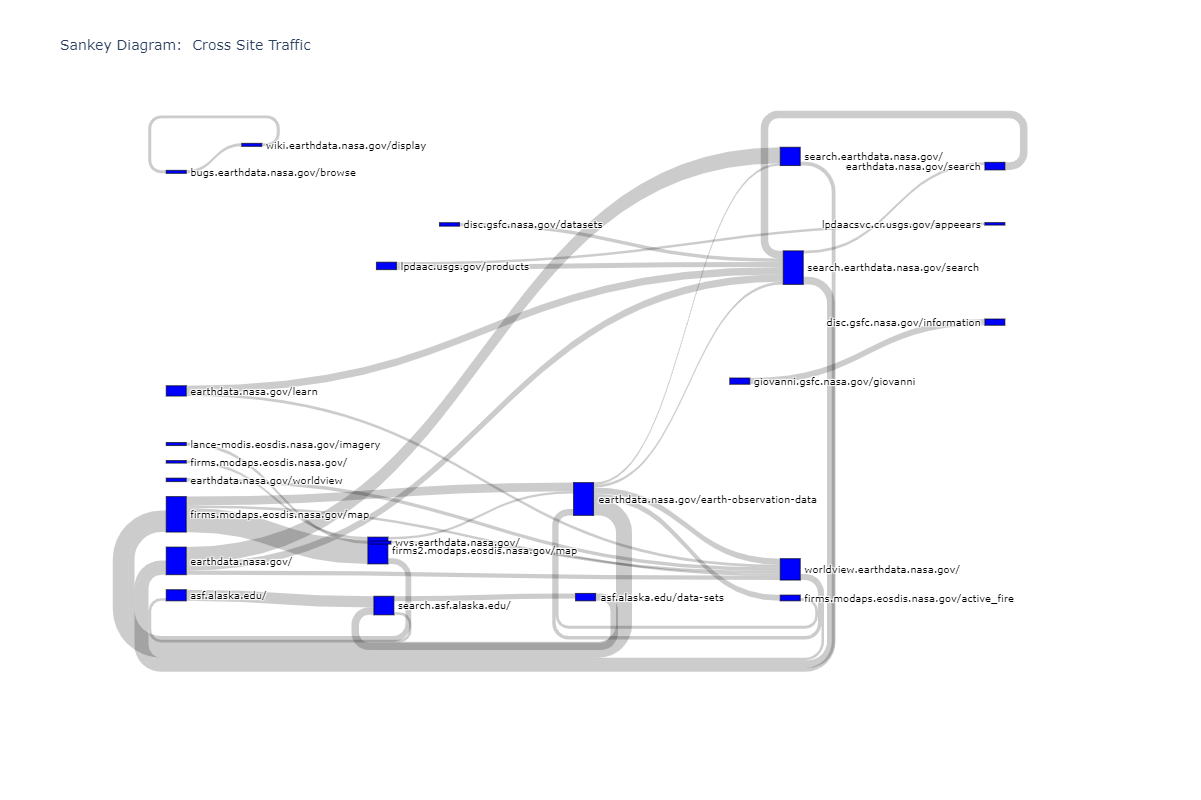

In [13]:
# Sankey Diagram
chart_data = {
    'chart_node' : {},
    'chart_node_id' : 0,
    'chart_edge' : {},
    'chart_edge_id' : 0,
    'chart_title' : 'Cross Site Traffic'
}


# Network Diagram
network_chart_data =  {
    'chart_node' : {},
    'chart_node_id' : 0,
    'chart_edge' : {},
    'chart_edge_id' : 0,
    'chart_title' : 'Cross Site Traffic'

}

metric='session_count'

sankeyEdgeLimit = 36

# Note, the Network diagram can contain more edges typically that the Sankey diagram.

networkEdgeLimit = 2000

edgeCount = 0

for (edge_id, edge) in sorted(edges.items(), key=lambda x: int(x[1][metric]), reverse=True):
    fromHit = hits[edge['from']]
    toHit   = hits[edge['to']]
    if edge['from'] == -1 or edge['to'] == -2: # Exclude Start and End edges
        pass
    #elif not(fromHit['host'] == 'disc.gsfc.nasa.gov' and toHit['host'] == 'disc.gsfc.nasa.gov'):
    #    pass
#    elif not('opendap' in fromHit['hit'] or 'opendap' in toHit['hit']): # Exclude Start and End edges
#        pass
    elif edge['from'] == edge['to']:             # Exclude self referencing edges
        pass
    elif fromHit['host'] == toHit['host']:
        pass
    elif 'urs' in fromHit['host'] or 'urs' in toHit['host']:
        pass
    else:
#    if True:
        edgeCount+=1
        
        if edgeCount <= sankeyEdgeLimit:           # Add edge to sankey chart data
            chart_data_add_edge(chart_data, edge, fromHit, toHit, metric)
        if edgeCount <= networkEdgeLimit:          # Add edge to network chart data
            add_network_chart_edge(network_chart_data, edge, fromHit, toHit, metric)
            
        if  edgeCount >= sankeyEdgeLimit and edgeCount >= networkEdgeLimit:
            break

print (edgeCount, 'edges used in network analysis')
#print (chart_data)
plot_network(network_chart_data, 'myAnalysis')
plot_sankey(chart_data, 'myAnalysis')


<h2>Page Analysis Functions</h2>

In [32]:
def pageevent_text(hit):
    myHit = ""
    myEventText = ""
    if hit['type'] == 'PAGE':
        myHit = hit['page']
    else:
        if hit['type'] == 'EVENT' and 'event' in hit:
            myEventText = json.dumps(hit['event'])
            myHit = hit['page'] + '~' + myEventText
        else:
            myHit = hit['page']

    return myHit



def get_path(x, c, s, h, cl, path_id, path_list):
    #print (cl[c]['s'][s]['h'][h])
    #print ('h=', h, cl[c]['s'][s]['h'])
    #print ('x=', x)
    myList = [None] * len(x)
    #print (myList)
    for i in range(len(x)):
        offset = x[i]
            #print('i=',i, "offset=", offset, "h=", h, "h+i=", h+i)
        if h+offset < 0:
            #print (i, 'None')
            myList[i]='None'
        elif h+offset == 0:
            #print (i, '-1')
            myList[i]='-1'
        elif h+offset > len(cl[c]['s'][s]['h'])+1:
            #print (i, None)
            myList[i]='None'
        elif h+offset == len(cl[c]['s'][s]['h'])+1:
            myList[i]='-2'
        else:
                #print (i)
                #print ('h=', h, 'offset=', offset, 'len=', len(cl[c]['s'][s]['h']))
                #print (cl[c]['s'][s]['h'][h+offset]['hit_id'])
                #print ('h=', h, 'offset=', offset)
            myList[i]=str(cl[c]['s'][s]['h'][h+offset]['hit_id'])
    #print (myList)
    path_key = '~'.join(myList)
                #print (path_key)
    session_key = c + '~' + str(s)
        
    if path_key in path_list:
        
        path_list[path_key]['hit_count']+=1
        
        if c in path_list[path_key]['c']:
            pass
        else:
            path_list[path_key]['c'].append(str(c))
            
        if session_key in path_list[path_key]['s']:
            pass
        else:
            path_list[path_key]['s'].append(session_key)
            
    else:
        path_list[path_key]={ 'hit_count' : 1,
                                    'c' : [str(c)],
                                    's' : [session_key]
                            }
    path_id += 1

    return path_id



def add_path_edge(path_list, p, path_edges):
    myList = p.split('~')
    if p == 'None~-1~6~979~1221~-2':
        print ("DEBUG A: path=", p)
        print ('DEBUG A:', p, path_list[p])
        print('Function: add_path_edge A', myList)
        
    #print ('len=', len(myList))
    for i in range(len(myList)):
        #print (i)
        if i < len(myList)-1:
            if myList[i] == 'None' or myList[i+1] == 'None':
                pass
            else:
                myEdge = myList[i] + '~' + myList[i+1]
                #print (i, myEdge, path_list[p]['hit_count'])
                if myEdge in path_edges:
                    path_edges[myEdge]['hit_count'] += path_list[p]['hit_count']
                    #if path_list[p]['hit_count'] > path_edges[myEdge]['hit_count']:
                    #    path_edges[myEdge]['hit_count'] = path_list[p]['hit_count']
                    path_edges[myEdge]['client_count'] += len(path_list[p]['c'])
                    path_edges[myEdge]['session_count'] += len(path_list[p]['s'])
                else:
                    path_edges[myEdge] = {
                        'from'      : int(myList[i]),
                        'to'        : int(myList[i+1]),
                        'hit_count' : path_list[p]['hit_count'],
                        'client_count'  : len(path_list[p]['c']),
                        'session_count' : len(path_list[p]['s'])
                    }
    
    return

In [33]:
def get_path_edges(node_id, left, right, cl):
    #x=[-4, -3, -2, -1, 0, 1, 2]
    x=[]
    nodesLeft=left
    nodesRight=right
    for i in range(nodesLeft, nodesRight+1):
        #print (i)
        x.append(i)
    cnt=0
    path_list={}
    path_id = 0
    #print ('node_id', node_id)
    for c in cl:
        for s in cl[c]['s']:
            for h in sorted(cl[c]['s'][s]['h'].keys()):
                myHit = cl[c]['s'][s]['h'][h]
                if myHit['hit_id'] == node_id: # and 'gpm_mergir' in myHit and 'firms' not in cl[c]['s'][s]['h'][h]['page']:
                    cnt+=1
                    #print ('cnt=', cnt, h, cl[c]['s'][s]['h'][h])
                    path_id = get_path(x, c, s, h, cl, path_id, path_list)
                    #print ('path_id=', path_id, path_list)

    #print ('path_list=', path_list)

#    print ('Function get_path_edges: None~-1~6~979~1221~-2', path_list['None~-1~6~979~1221~-2'])
        
    edgeCount=0

    path_edges={}
    path_edge_id = 0
    edgeLimit=999964
    edgeCount=0

    for (p, path) in sorted(path_list.items(), key=lambda x: ( x[1]['hit_count']), reverse=True):
        path_edge_id = add_path_edge(path_list, p, path_edges)
        edgeCount+=1
        if edgeCount > edgeLimit:
            break

#    print ('Function get_path_edges After For: None~-1~6~979~1221~-2', path_list['None~-1~6~979~1221~-2'])

#    for e in path_edges:
#        path_edges[e]['client_count']= len(path_edges[e]['c'])
#        path_edges[e]['session_count'] = len(path_edges[e]['s'])


#    for e in sorted(path_edges):
#        print (e, ',' , end='')
#    print()
#    print ('Path Edges Count:', len(path_edges))

    path_data = {
        'path_list'  : path_list,
        'path_edges' : path_edges
    }
    #print ('path_data=', path_data)
    return path_data

<h2>Analysis by specific webpage</h2>

In [35]:
cfg = {
    'range' : {
        'start' : '20201001', # YYYYMMDD
        'end'   : '20201124'  # YYYYMMDD
    },
    'include_events' : False,  # or False, # Options ['eventCategory', 'eventLabel', 'eventAction', 'eventValue']
    'path_limit' : False,          # False or integer
    'include_hosts' : ['earthdata.nasa.gov'], # includes sessions where hostname included at least once ('all' - in clause not added to where)
    'content_groups' : False   # False or see comment below
}


#cfg['content_groups'] = {
#    1 : {'cg':'/dataset_cg',   'match' : ".+dataset"}
#}

#cfg['content_groups'] =  { 
#    1 : {'cg':'/download',   'match' : "/download"},
#    3 : { 'cg' : '/',        'match' : '/', 'host' : ['urs.earthdata.nasa.gov'],
#    4 : {'cg' : '/sg',       'match' : '/search/granules'}}
#}



print(datetime.datetime.now())

cl={}
cl = get_bigquery_data(cfg)
print(datetime.datetime.now())

2020-11-25 16:26:33.664093
getting data from BigQuery ...
done. 954526 rows processed.
2020-11-25 16:33:22.178589


In [36]:
# Create the hits dictionary

hits={}
hits=create_nodes(cl, cfg)
print(datetime.datetime.now())

# If you want to dump the cl dictionary as a json file, uncomment below.
# with open('data.json', 'w') as f:
#    json.dump(cl, f, indent=1)

# Create the edges dictionary

edges={}
edges=create_edges(cl)
print(datetime.datetime.now())

print (len(edges))

print ('cfg=', json.dumps(cfg, indent=4))

creating nodes.
create nodes done. 28277
2020-11-25 16:42:38.896194
done create edges. 121035
2020-11-25 16:42:41.999282
121035
cfg= {
    "range": {
        "start": "20201001",
        "end": "20201124"
    },
    "include_events": false,
    "path_limit": false,
    "include_hosts": [
        "earthdata.nasa.gov"
    ],
    "content_groups": false
}


Search: earthdata.nasa.gov/learn/what-is-sar
Page: earthdata.nasa.gov/learn/what-is-sar
edges created: 65


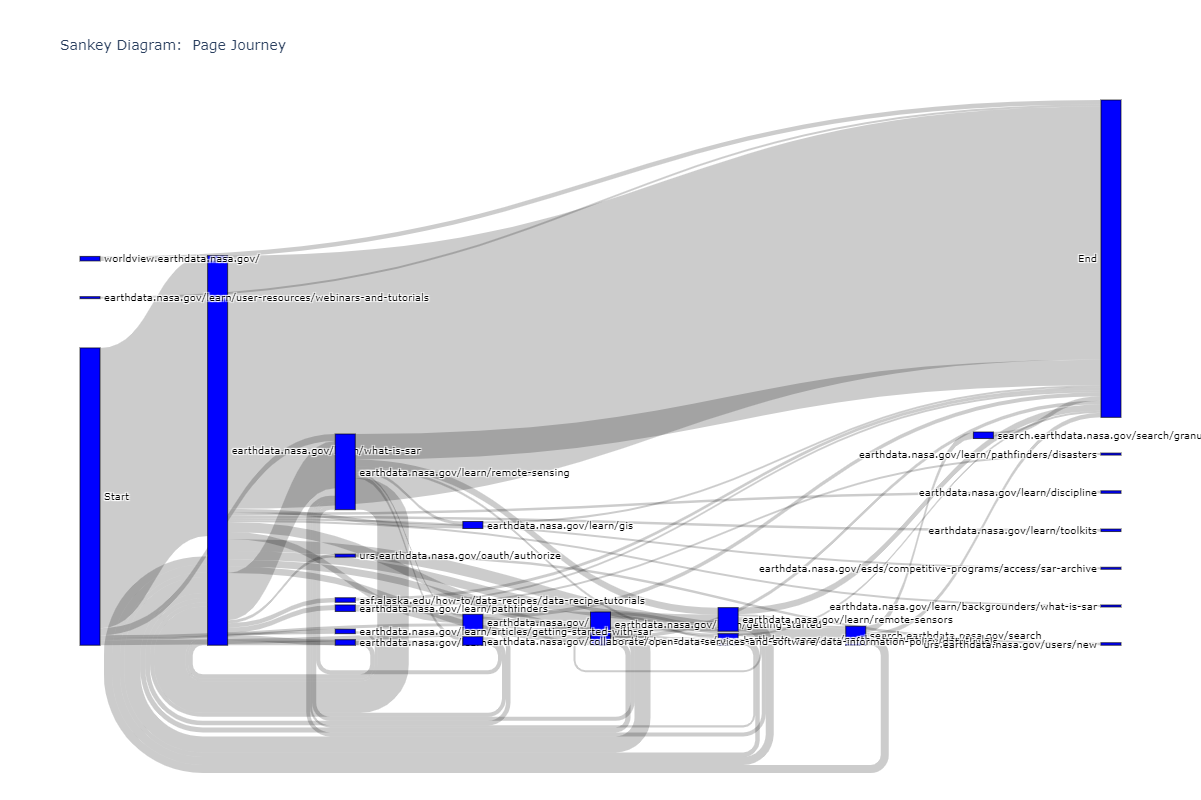

Created file: network_earthdata.nasa.gov_learn_what-is-sar.html
Page: earthdata.nasa.gov/learn/what-is-sar.
edges created: 3


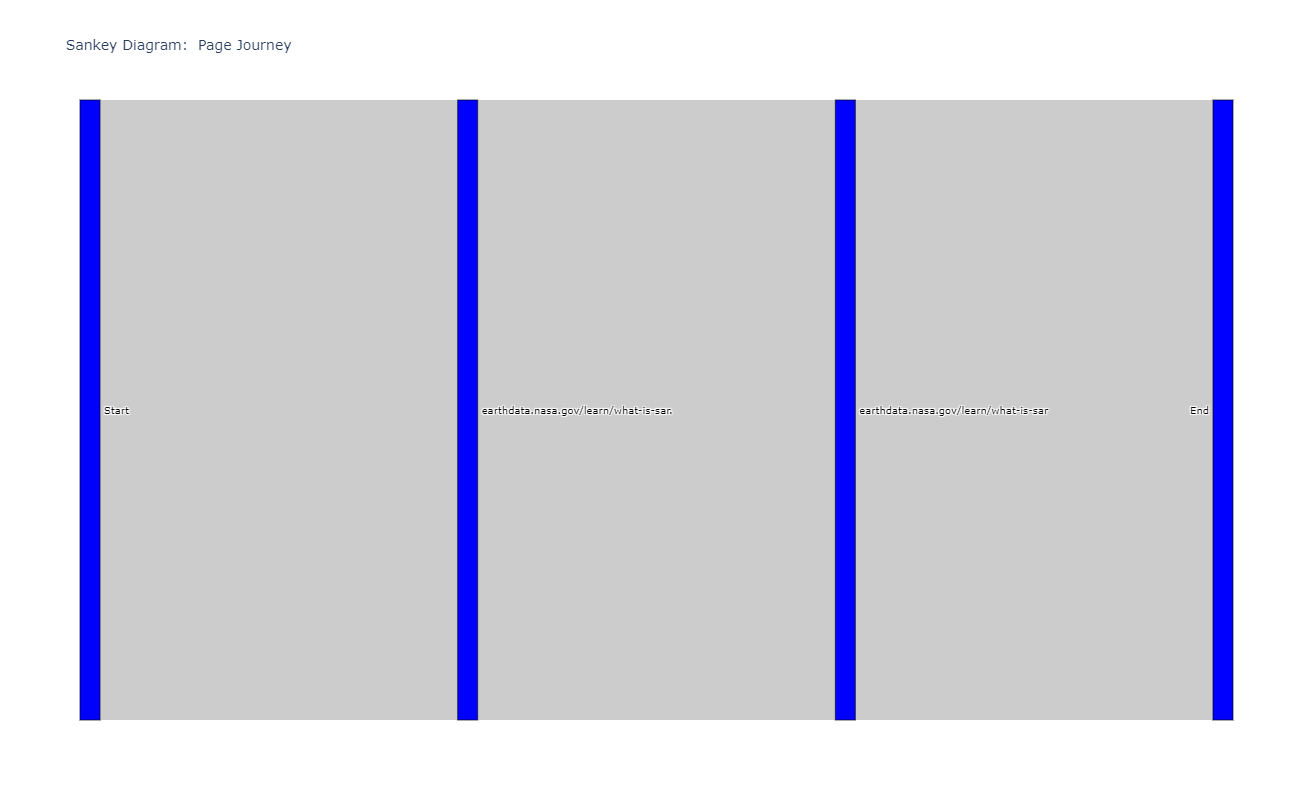

Created file: network_earthdata.nasa.gov_learn_what-is-sar..html
Search: earthdata.nasa.gov/learn/articles/feature-articles/biodiversity-articles
Page: earthdata.nasa.gov/learn/articles/feature-articles/biodiversity-articles
edges created: 65


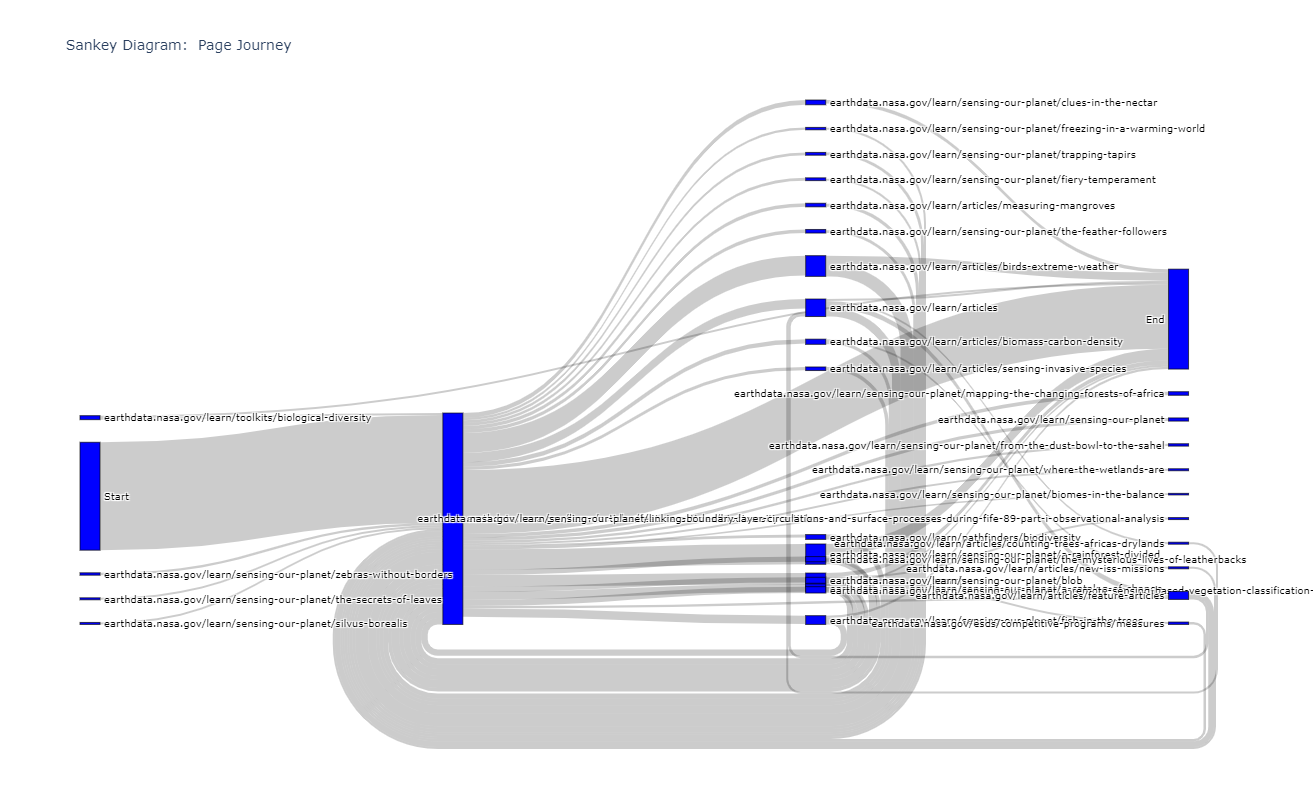

Created file: network_earthdata.nasa.gov_learn_articles_feature-articles_biodiversity-articles.html
Search: earthdata.nasa.gov/learn/pathfinders/biodiversity
Page: earthdata.nasa.gov/learn/pathfinders/biodiversity/species-distribution
edges created: 65


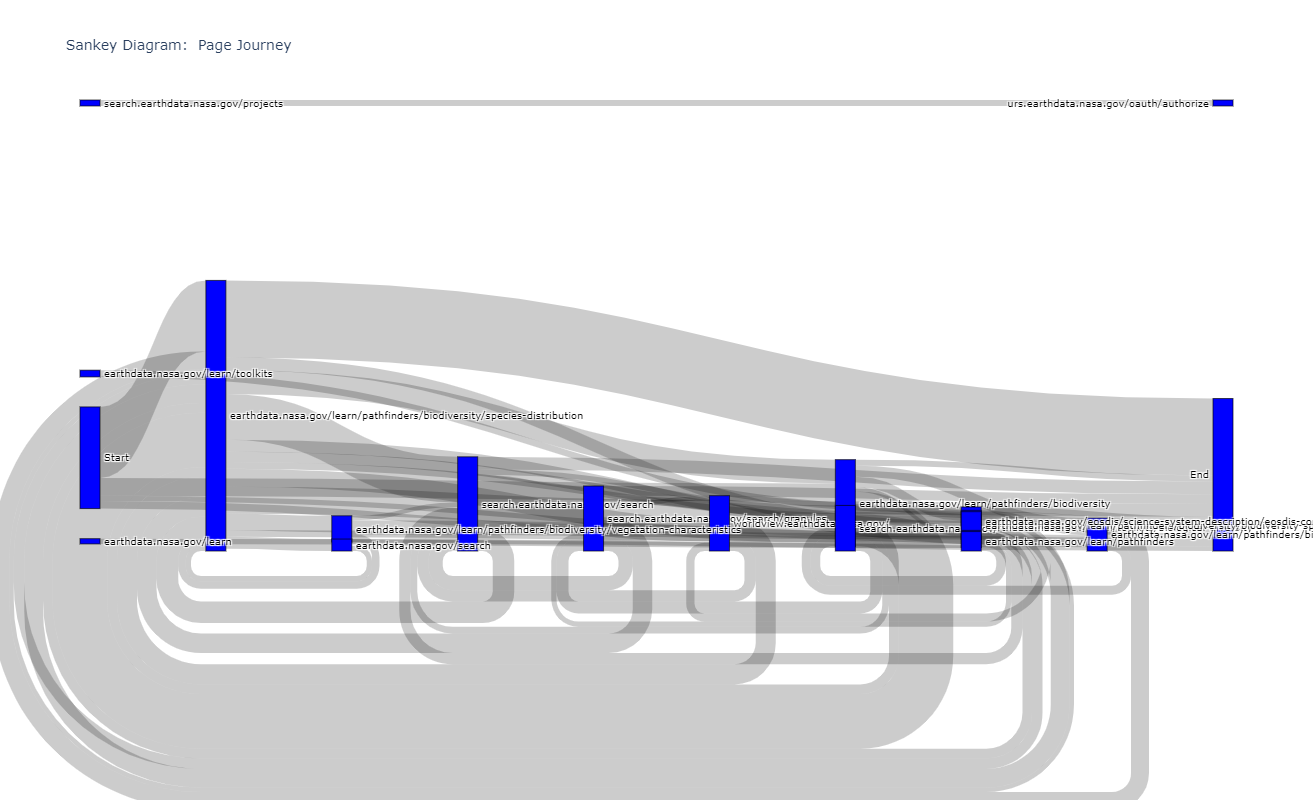

Created file: network_earthdata.nasa.gov_learn_pathfinders_biodiversity_species-distribution.html
Page: earthdata.nasa.gov/learn/pathfinders/biodiversity
edges created: 65


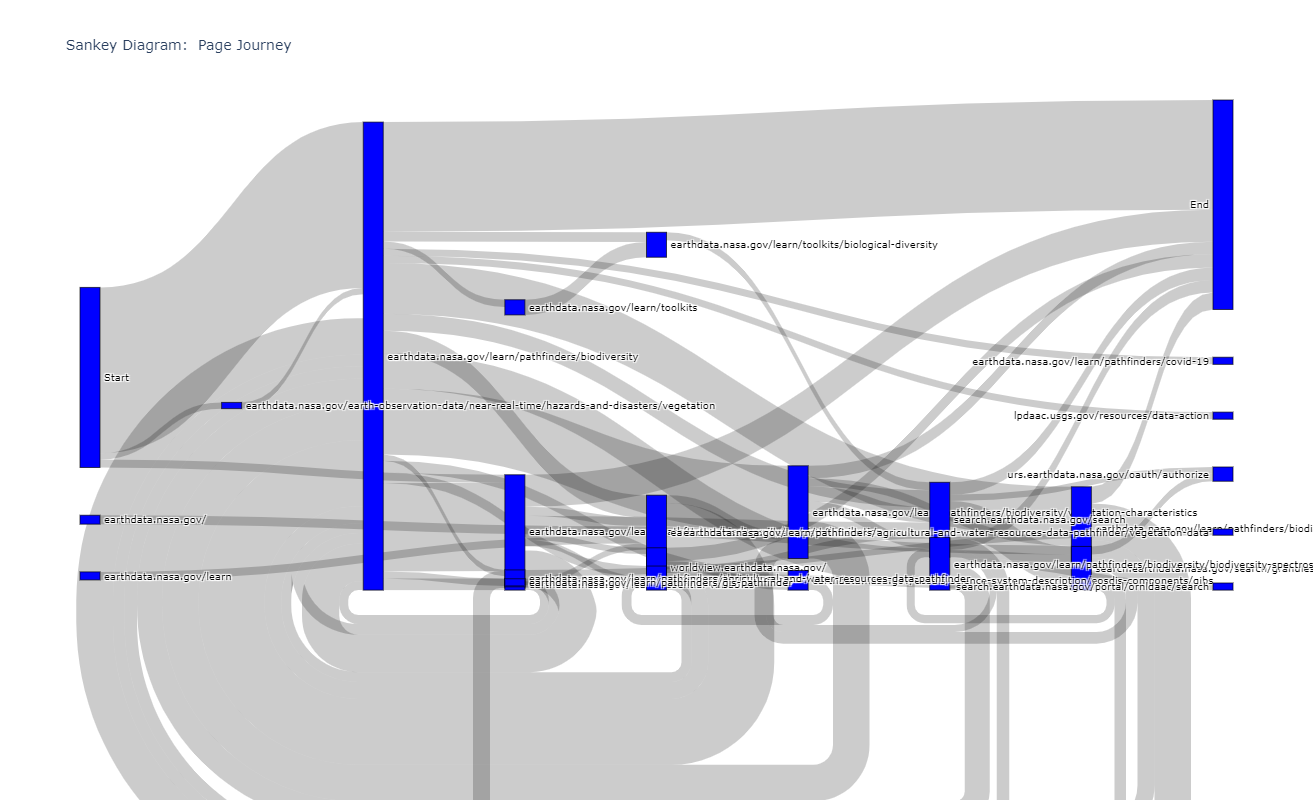

Created file: network_earthdata.nasa.gov_learn_pathfinders_biodiversity.html
Page: earthdata.nasa.gov/learn/pathfinders/biodiversity/human-impacts
edges created: 65


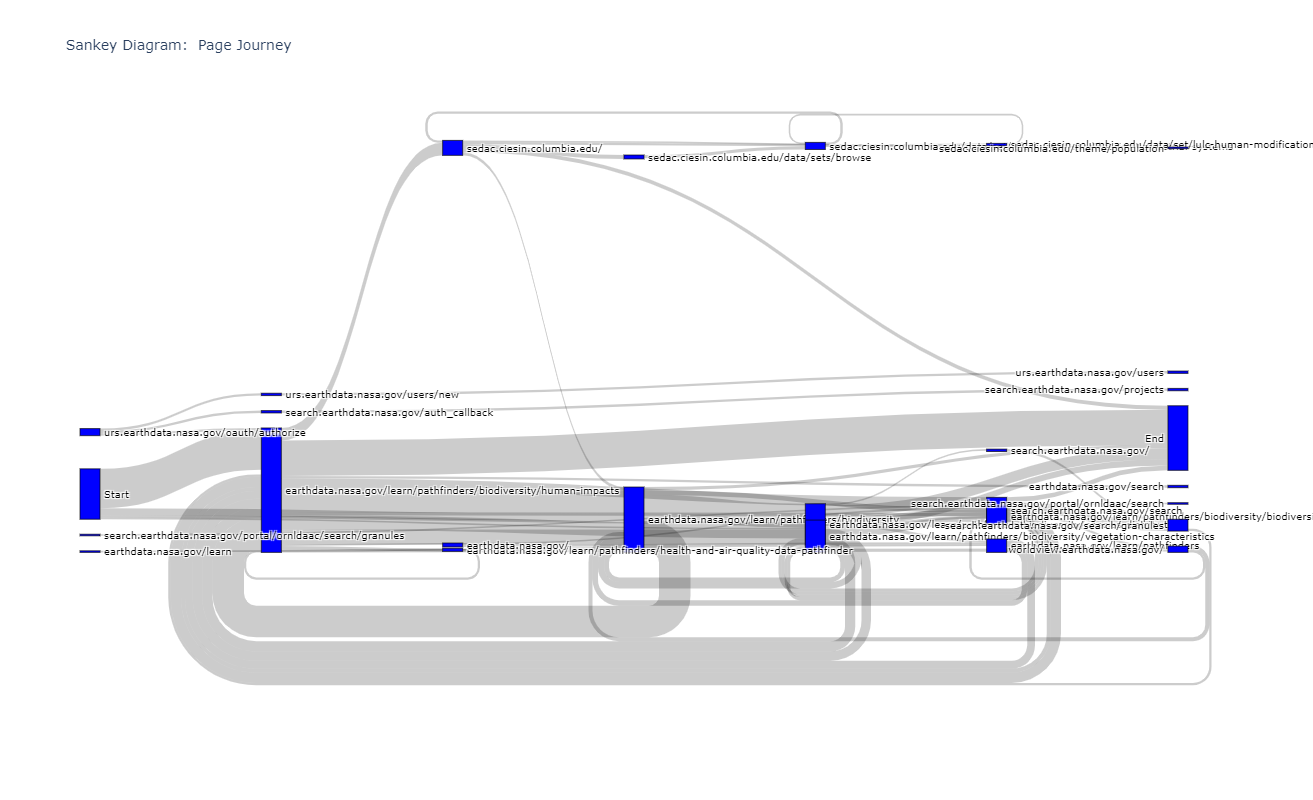

Created file: network_earthdata.nasa.gov_learn_pathfinders_biodiversity_human-impacts.html
Page: earthdata.nasa.gov/learn/pathfinders/biodiversity/biodiversity-spectroscopy
edges created: 65


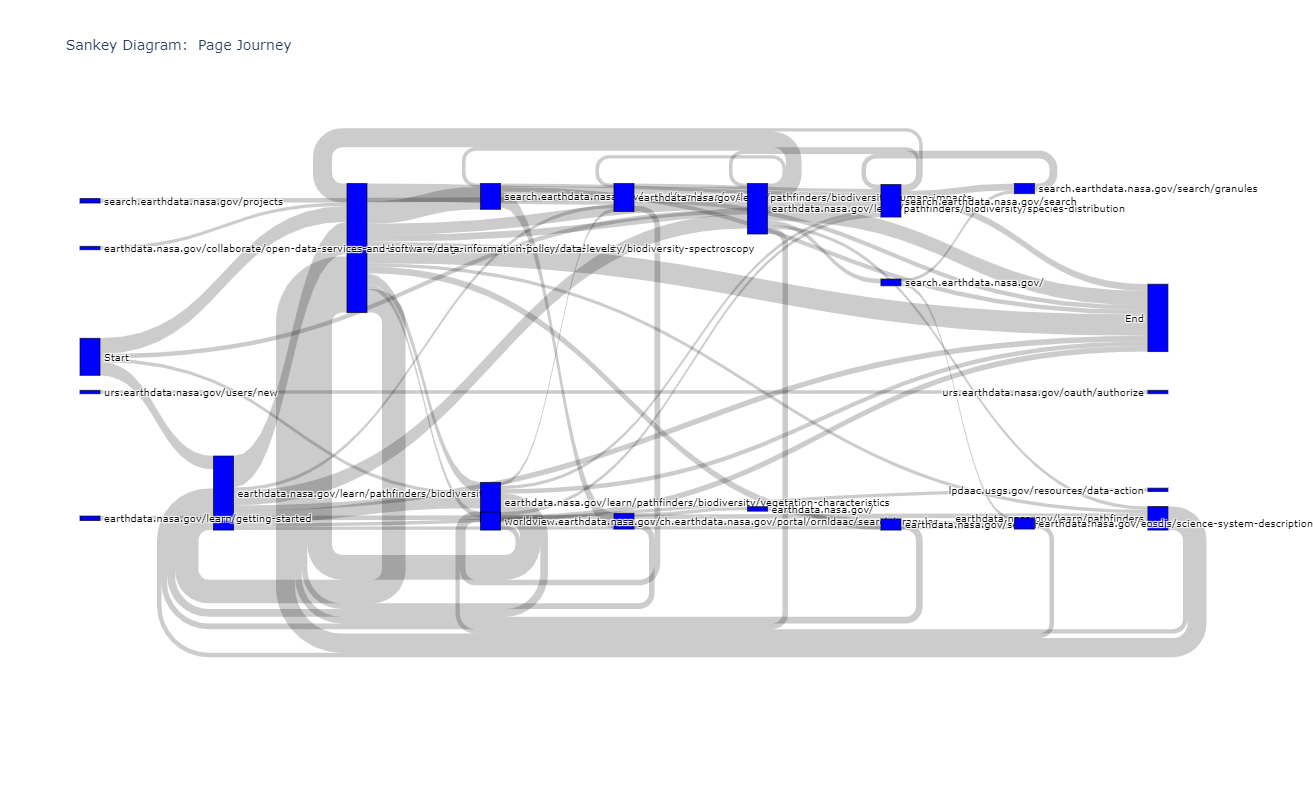

Created file: network_earthdata.nasa.gov_learn_pathfinders_biodiversity_biodiversity-spectroscopy.html
Page: earthdata.nasa.gov/learn/pathfinders/biodiversity/vegetation-characteristics
edges created: 65


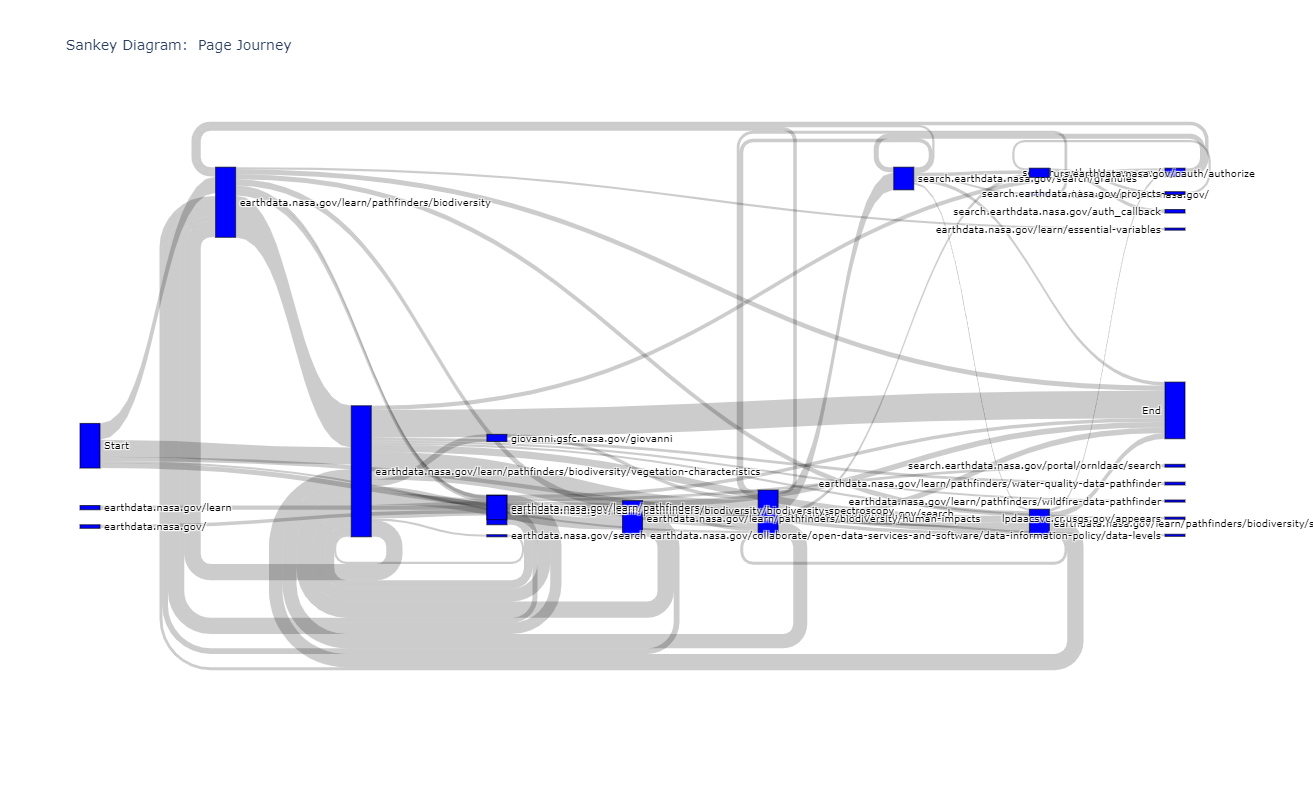

Created file: network_earthdata.nasa.gov_learn_pathfinders_biodiversity_vegetation-characteristics.html
Search: earthdata.nasa.gov/learn/articles/measuring-mangroves
Page: earthdata.nasa.gov/learn/articles/measuring-mangroves
edges created: 65


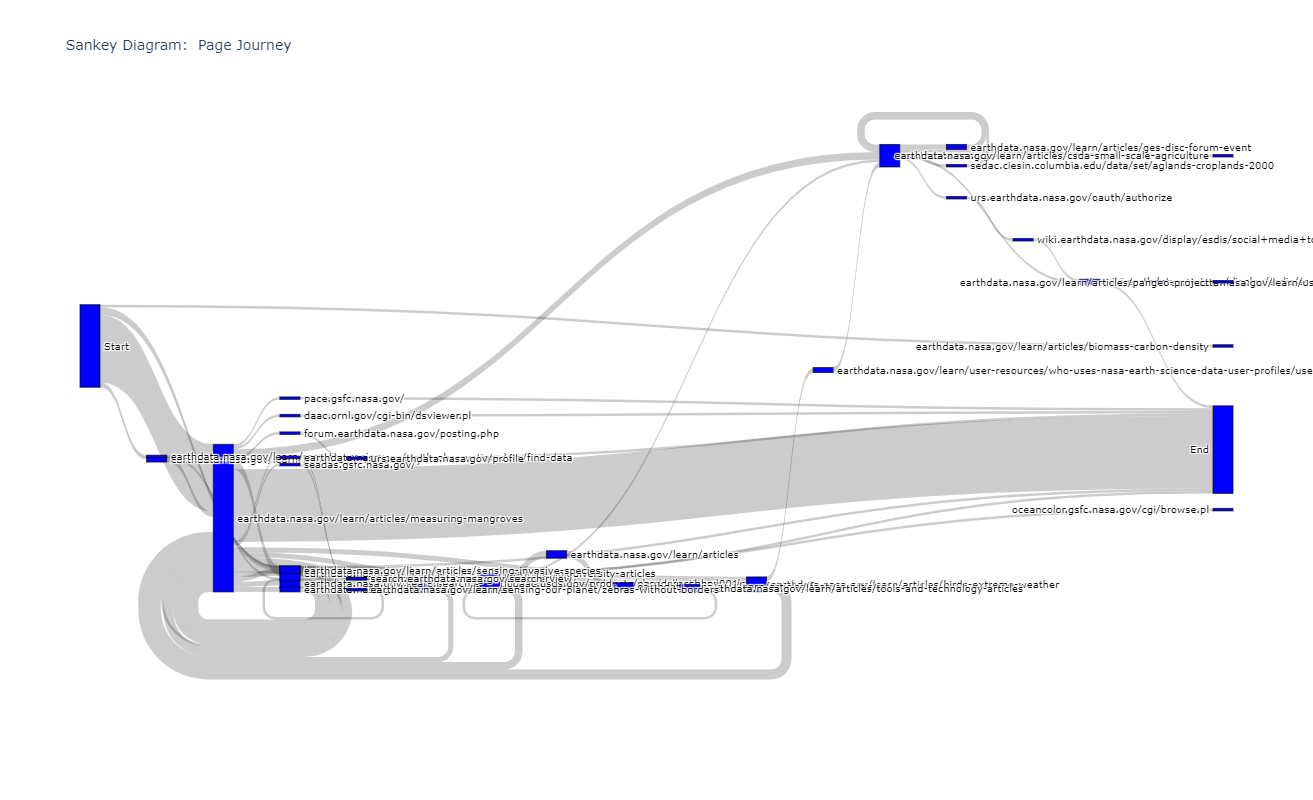

Created file: network_earthdata.nasa.gov_learn_articles_measuring-mangroves.html
Search: earthdata.nasa.gov/learn/toolkits/biological-diversity
Page: earthdata.nasa.gov/learn/toolkits/biological-diversity
edges created: 65


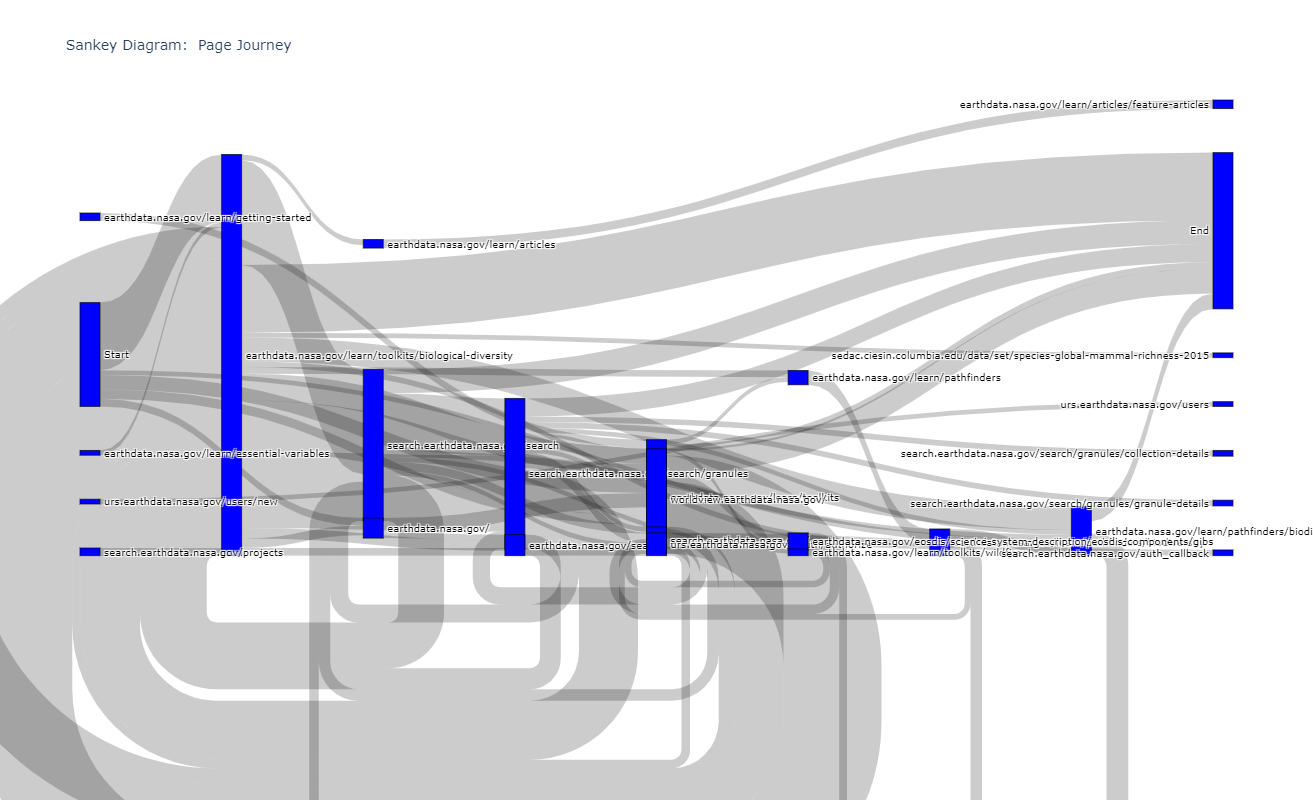

Created file: network_earthdata.nasa.gov_learn_toolkits_biological-diversity.html


In [50]:
pages=[
    'earthdata.nasa.gov/learn/what-is-sar',
    'earthdata.nasa.gov/learn/articles/feature-articles/biodiversity-articles',
    'earthdata.nasa.gov/learn/pathfinders/biodiversity',
    'earthdata.nasa.gov/learn/articles/measuring-mangroves',
    'earthdata.nasa.gov/learn/toolkits/biological-diversity',
    'earthdata.nasa.gov/learn/articles/sensing-invasive-species',
    'earthdata.nasa.gov/learn/articles/biomass-carbon-density',
    'earthdata.nasa.gov/learn/articles/birds-extreme-weather',
    'earthdata.nasa.gov/learn/articles/ecological-data-made-easy',
    'earthdata.nasa.gov/learn/essential-variables',
    'earthdata.nasa.gov/learn/articles/tools-and-technology-articles/remote-sensing-for-ecological-research'
]

#pages=[
#    'earthdata.nasa.gov/learn/pathfinders/covid-19/environmental-impacts',
#    'earthdata.nasa.gov/learn/articles/20-years-of-precipitation-data',
#    'earthdata.nasa.gov/learn/articles/biodiversity-articles',
#    'earthdata.nasa.gov/learn/articles/biomass-carbon-density',
#    'earthdata.nasa.gov/learn/articles/birds-extreme-weather',
#    'earthdata.nasa.gov/learn/articles/cloud-data-egress',
#    'earthdata.nasa.gov/learn/articles/csda-small-scale-agriculture',
#    'earthdata.nasa.gov/learn/articles/data-latency',
#    'earthdata.nasa.gov/learn/articles/ecological-data-made-easy',
#    'earthdata.nasa.gov/learn/articles/essential-variables',
#earthdata.nasa.gov/learn/articles/feature-articles
#earthdata.nasa.gov/learn/articles/feature-articles/biodiversity-articles
#earthdata.nasa.gov/learn/articles/feature-articles/disaster-articles
#earthdata.nasa.gov/learn/articles/feature-articles/freshwater-articles
#earthdata.nasa.gov/learn/articles/feature-articles/health-and-air-quality-articles
#earthdata.nasa.gov/learn/articles/feature-articles/health-and-air-quality-articles/find-no2-data
#earthdata.nasa.gov/learn/articles/feature-articles/introducing-terra-fusion
#earthdata.nasa.gov/learn/articles/feature-articles/nighttime-images-wuhan
#earthdata.nasa.gov/learn/articles/feature-articles/sea-level-articles
#earthdata.nasa.gov/learn/articles/feature-articles/tools-and-technology-articles
#earthdata.nasa.gov/learn/articles/feature-articles/wildfire-articles
#earthdata.nasa.gov/learn/articles/features-articles/biodiversity-articles
#earthdata.nasa.gov/learn/articles/getting-started-with-sar
#earthdata.nasa.gov/learn/articles/measuring-mangroves
#earthdata.nasa.gov/learn/articles/pangeo-project
#earthdata.nasa.gov/learn/articles/sensing-invasive-species
#earthdata.nasa.gov/learn/articles/small-satellite-data-explorer
#earthdata.nasa.gov/learn/articles/solving-data-puzzle-of-sea-level-rise
#earthdata.nasa.gov/learn/articles/tools-and-technology-articles
#earthdata.nasa.gov/learn/articles/tools-and-technology-articles/ghrc-moves-to-the-earthdata-cloud
#earthdata.nasa.gov/learn/articles/tools-and-technology-articles/mur-sst
#earthdata.nasa.gov/learn/articles/tools-and-technology-articles/remote-sensing-for-ecological-research
#earthdata.nasa.gov/learn/articles/wildfires-cant-hide-from-earth-observing-satellites
#earthdata.nasa.gov/learn/essential-variables
#earthdata.nasa.gov/learn/pathfinders
#earthdata.nasa.gov/learn/pathfinders/agricultural-and-water-resources-data-pathfinder
#earthdata.nasa.gov/learn/pathfinders/agricultural-and-water-resources-data-pathfinder/land-data
#earthdata.nasa.gov/learn/pathfinders/agricultural-and-water-resources-data-pathfinder/vegetation-data
#earthdata.nasa.gov/learn/pathfinders/agricultural-and-water-resources-data-pathfinder/water-data
#earthdata.nasa.gov/learn/pathfinders/biodiversity
#earthdata.nasa.gov/learn/pathfinders/biodiversity/biodiversity-spectroscopy
#earthdata.nasa.gov/learn/pathfinders/biodiversity/human-impacts
#earthdata.nasa.gov/learn/pathfinders/biodiversity/species-distribution
#earthdata.nasa.gov/learn/pathfinders/biodiversity/vegetation-characteristics
#earthdata.nasa.gov/learn/pathfinders/covid-19
#earthdata.nasa.gov/learn/pathfinders/covid-19/seasonality
#earthdata.nasa.gov/learn/pathfinders/covid-19/water
#earthdata.nasa.gov/learn/pathfinders/disasters
#earthdata.nasa.gov/learn/pathfinders/disasters/cyclones
#    'earthdata.nasa.gov/learn/pathfinders/disasters/earthquakes-and-volcanoes',
#    'earthdata.nasa.gov/learn/pathfinders/disasters/extreme-heat',
#    'earthdata.nasa.gov/learn/pathfinders/disasters/floods-data-pathfinder',
#earthdata.nasa.gov/learn/pathfinders/disasters/landslides
#earthdata.nasa.gov/learn/pathfinders/disasters/learn/remote-sensing
#earthdata.nasa.gov/learn/pathfinders/gis-pathfinder
#earthdata.nasa.gov/learn/pathfinders/gis-pathfinder/geospatial-services
#earthdata.nasa.gov/learn/pathfinders/gis-pathfinder/gis-tools
#earthdata.nasa.gov/learn/pathfinders/health-and-air-quality-data-pathfinder
#    'earthdata.nasa.gov/learn/pathfinders/sea-level-change'
#earthdata.nasa.gov/learn/pathfinders/water-quality-data-pathfinder
#earthdata.nasa.gov/learn/pathfinders/wildfinder-data-pathfinder
#earthdata.nasa.gov/learn/pathfinders/wildfire-data-pathfinder
#earthdata.nasa.gov/learn/remote-sensing
#earthdata.nasa.gov/learn/toolkits
#earthdata.nasa.gov/learn/toolkits/biological-diversity
#earthdata.nasa.gov/learn/toolkits/freshwater-availability
#earthdata.nasa.gov/learn/toolkits/wildfires
#earthdata.nasa.gov/learn/what-is-sar
#]
#pages=['opendap']
path_data={}
cnt=0

nodesLeft=-3
nodesRight=8

for p in pages:
    print ('Search:', p)
    analysisLimit=10
    for h in hits:
        if p in hits[h]['hit']:
            cnt+=1
            
            path_data=get_path_edges(h, nodesLeft, nodesRight, cl)
            print ('Page:', hits[h]['hit'])
        
            chart_data = {'chart_node' : {},'chart_node_id' : 0,'chart_edge' : {},'chart_edge_id' : 0, 'chart_title' : 'Page Journey'}
            network_chart_data =  {'chart_node' : {},'chart_node_id' : 0,'chart_edge' : {},'chart_edge_id' : 0, 'chart_title' : 'Page Journey'}

    # Edges/Nodes disappearing on subsequent iterations is typically do to ordering and edgeLimit setting.

            edgeCount = 0
            sankeyLimit = 65
            networkLimit = 50

            #None~-1~6~979~1221~-2
            path_count=0
            path_limit=20
#            for (p, path) in sorted(path_data['path_list'].items(), key=lambda x: ( x[1]['hit_count']), reverse=True):
#                path_count+=1
#                if path_count <= path_limit:
#                    print (p, path['hit_count'], len(path['c']), len(path['s']) )
#                else:
#                    break
                        
                
                
            for (e, edge) in sorted(path_data['path_edges'].items(), key=lambda x: ( x[1]['client_count']), reverse=True):
            
                #if edge['from'] == -1 or edge['to'] == -2:
                #    pass
                if edge['from'] == edge['to']:
                    pass
                else:
                    toHit   = hits[ edge['to'  ] ]
                    fromHit = hits[ edge['from'] ]
                    if edgeCount < sankeyLimit:
                        chart_data_add_edge(chart_data, edge, fromHit, toHit, 'hit_count')
                    if edgeCount < networkLimit:
                        add_network_chart_edge(network_chart_data, edge, fromHit, toHit, 'hit_count')
                    edgeCount +=1
                    if edgeCount >= sankeyLimit and edgeCount >= networkLimit:
                        break

            print ('edges created:', edgeCount)
            plot_sankey(chart_data, hits[h]['hit'].replace('/', '_'))
            plot_network(network_chart_data, hits[h]['hit'].replace('/', '_'))
            
        if cnt >= analysisLimit:
            break
    if cnt >= analysisLimit:
        break

In [95]:
# Miscellaneous Debug Blocks

In [46]:
print (json.dumps(cl['1222719081.1604686441'], indent=1))


client_count=0
session_count=0
hit_count=0
for c in cl:
    client_count +=1
    for s in cl[c]['s']:
        session_count +=1
        for h in cl[c]['s'][s]['h']:
            hit_count+=1

print ('Date range:', cfg['range'], '\nEvents included:', cfg['include_events'], '\nHosts included:', cfg['include_hosts'])
print()
print ('clients:', client_count, '\nsessions:', session_count, '\nhits:', hit_count)
print()
for c in sorted(cl):
    print (c)
    print ( json.dumps(cl[c], indent=1))
    break


{
 "deviceCategory": "desktop",
 "browser": "Safari",
 "s": {
  "2": {
   "h": {
    "1": {
     "type": "PAGE",
     "time": "2020-11-06T19:44:27 +0000",
     "page": "earthdata.nasa.gov/learn/what-is-sar.",
     "hit_id": 5423,
     "event": null
    },
    "2": {
     "type": "PAGE",
     "time": "2020-11-06T19:44:32 +0000",
     "page": "earthdata.nasa.gov/learn/what-is-sar",
     "hit_id": 530,
     "event": null
    }
   }
  }
 }
}
Date range: {'start': '20201001', 'end': '20201124'} 
Events included: False 
Hosts included: ['earthdata.nasa.gov']

clients: 82354 
sessions: 109019 
hits: 954526

0JvZzchv893e3dtAsG5IzFUdLv3aBQZcIGotcXZVpbCckco_Qh4wPfJTiLhihKtn
{
 "deviceCategory": "mobile",
 "browser": "Chrome",
 "s": {
  "2": {
   "h": {
    "1": {
     "type": "PAGE",
     "time": "2020-11-02T17:21:09 +0000",
     "page": "earthdata.nasa.gov/earth-observation-data/near-real-time/hazards-and-disasters/air-quality",
     "hit_id": 1,
     "event": null
    },
    "2": {
     "type"

In [45]:
cnt = 0
for h in hits:
    if 'is-sar' in hits[h]['hit'] or 'is-sar' in hits[h]['hit']:
        print ('id=', h, hits[h]['hit'] , '\n', json.dumps(hits[h], indent=1))
        cnt+=1
    if cnt> 100:
        break

id= 449 earthdata.nasa.gov/learn/backgrounders/what-is-sar 
 {
 "hit": "earthdata.nasa.gov/learn/backgrounders/what-is-sar",
 "type": "P",
 "host": "earthdata.nasa.gov",
 "hit_count": 187,
 "c": [
  "10048570.1603678528",
  "10079981.1605869593",
  "1034308890.1606155400",
  "1074087682.1604924145",
  "1081159338.1606122887",
  "1091713713.1604933626",
  "1106612271.1604323012",
  "1145555307.1587480268",
  "1170550168.1603322353",
  "1182901828.1602687747",
  "1191004133.1604581428",
  "1195902661.1606184977",
  "1233740560.1606059347",
  "1271895172.1600876044",
  "1272541631.1600557869",
  "1280292769.1606161417",
  "1290240884.1606066602",
  "1319866872.1592149009",
  "1319867999.1604424792",
  "1331147198.1537325891",
  "1341861006.1602143856",
  "1452529629.1604073773",
  "148301124.1605806860",
  "1489895350.1606227913",
  "1531182541.1606158255",
  "1552727742.1563209229",
  "1574549345.1606133044",
  "1575417916.1605675392",
  "1590615395.1599142079",
  "1628151494.1605999363"

In [81]:
cnt=0
for (edge_id, edge) in sorted(edges.items(), key=lambda x: int(x[1][metric]), reverse=True):
    if edge['to'] ==15840:
        print ('Example edge: id=', edge_id, '\n', json.dumps(edge))
        cnt+=1
    if cnt > 3:
        break

Example edge: id= 1440~15840 
 {"id": 35462, "from": 1440, "to": 15840, "hit_count": 33, "session_count": 17, "client_count": 16}
Example edge: id= 15840~15840 
 {"id": 68717, "from": 15840, "to": 15840, "hit_count": 1, "session_count": 1, "client_count": 1}
Example edge: id= 5~15840 
 {"id": 75058, "from": 5, "to": 15840, "hit_count": 1, "session_count": 1, "client_count": 1}


In [64]:
cnt=0
for h in hits:
    if hits[h]['type']=='E':
        print (h, hits[h]['hit'], 'h count:', hits[h]['hit_count'], 's count:', len(hits[h]['s']), 'c count:', len(hits[h]['c']) )
        print (hits[h] )
        cnt+=1
    if cnt >= 10:
        break

In [61]:
x = pd.DataFrame.from_dict(hits, orient='index')
pd.set_option("max_rows", 1000)
x[['hit_count', 'type', 'hit']].sort_values(by=['hit_count'], ascending=False)
#x.groupby(['host']).sum()


,hit_count,type,hit
6,13397,P,urs.earthdata.nasa.gov/oauth/authorize
3,7633,P,nsidc.org/arcticseaicenews
8,7039,P,firms.modaps.eosdis.nasa.gov/map
212,5520,P,sres.ciesin.org/
32,4510,P,worldview.earthdata.nasa.gov/
...,...,...,...
6667,1,P,wiki.earthdata.nasa.gov/display/~edc_snyk_user
6666,1,P,wiki.earthdata.nasa.gov/display/ccp/snyk+requi...
6665,1,P,wiki.earthdata.nasa.gov/display/ccp/on+boardin...
-1,-1,EVENT,Start


In [ ]:
df_edges = pd.DataFrame.from_dict(edges, orient='index')
pd.set_option("max_rows", 100)
df_edges.sort_values(['hit_count'], ascending=False)

In [ ]:
# Deprecated, if graph traversal is needed, use a graph database like neo4j.
#def get_paths(origin, currentNode, dir, step, s_list, currentPath):